# 1. Introduction & Contexte

Depuis 1982, la société **Infologic** conçoit et intègre des solutions logicielles dédiées à l’agroalimentaire.  
L’évolution et la maintenance de ces logiciels reposent notamment sur des **tests continus** réalisés par des équipes internes.  
Chaque testeur utilise différents profils afin de vérifier le bon fonctionnement de multiples fonctionnalités du logiciel.

Actuellement, lorsqu’un problème est détecté, les testeurs doivent reporter leurs actions sous leur vrai profil, ce qui demande des manipulations longues et fastidieuses.  

**Objectif du projet :**  
Étudier la possibilité d’**identifier automatiquement l’utilisateur** d’un logiciel à partir de ses **traces d’utilisation** (séquences d’actions effectuées).  
Pour cela, nous allons construire un **modèle de classification** basé sur des techniques de **Machine Learning**.

Un tel modèle pourrait :
- faciliter le suivi des tests et des utilisateurs internes ;
- contribuer à la **détection d’usurpations** ou d’**intrusions logicielles**.

**Métrique d’évaluation : F1-score moyen**  
Le F1-score mesure l’équilibre entre la **précision** et le **rappel** :
$$
F1 = 2 \times \frac{P \times R}{P + R}
$$
Un bon modèle cherchera à maximiser simultanément ces deux aspects.


### *Import des bibliotheques nessecaires*

In [5]:

import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from scipy.sparse import hstack, csr_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, StackingClassifier


from xgboost import XGBClassifier
import xgboost as xgb

### *Définition des variables, fonctions et classes utiles pour la suite*

In [6]:
#expression régulière principale pour parser les actions utilisateur
ACTION_RE = re.compile(
    r"^(?P<base>[^(<$1]+?)"              # action de base, ex: "Création d'un écran"
    r"(?:\((?P<ctrl>[^)]*)\))?"          # (controller/écran)
    r"(?:<(?P<conf>[^>]+)>)?"            # <configuration>
    r"(?:\$(?P<chain>[^$]+)\$)?"         # $chaine$
    r"(?P<edit>1)?$"                     # flag édition "1"
)

def read_ds(ds_name: str):
    """Lit un fichier CSV d’actions utilisateur et définit dynamiquement les colonnes."""
    with open(f'../data/interim/{ds_name}.csv') as f:

        max_actions = max((len(str(c).split(",")) for c in f.readlines()))
        f.seek(0)
        _names = ["util", "navigateur"] if "train" in ds_name else ["navigateur"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype=str)

def row_to_sequence(row, start_col=2):
    """Transforme une ligne du dataset en séquence d’actions."""
    vals = []
    for c in row.index[start_col:]:
        v = row[c]
        if pd.isna(v): break
        vals.append(str(v))
    return vals

def normalize_token(tok: str) -> list:
    """Nettoie et segmente un token brut en sous-tokens normalisés."""
    tok = tok.strip()
    if not tok: return []
    if tok.startswith("t") and tok[1:].isdigit():
        return [f"TWIN_{tok[1:]}"]

    m = ACTION_RE.match(tok)
    if not m:
        return [tok.replace(" ", "_")]
    base = m.group("base").strip().replace(" ", "_")
    ctrl = (m.group("ctrl") or "").strip().replace(".", "_").replace(" ", "_")
    conf = (m.group("conf") or "").strip().replace(" ", "_")
    chain = (m.group("chain") or "").strip().replace(" ", "_")
    edit = m.group("edit")

    out = [f"A_{base}"]
    if ctrl:  out.append(f"C_{ctrl}")
    if conf:  out.append(f"CFG_{conf}")
    if chain: out.append(f"CH_{chain}")
    if edit:  out.append("EDIT_1")
    return out

def seq_to_text(seq_list):
    """Transforme une séquence de tokens en texte prêt pour la vectorisation TF-IDF."""
    toks = []
    for tok in seq_list:
        toks.extend(normalize_token(tok))
    return " ".join(toks)

def extract_temporal_features(actions):
    """
    Extrait des caractéristiques temporelles à partir d'une séquence d'actions.
    Les marqueurs temporels commencent par 't' et représentent des intervalles de 5s.
    """
    features = {}

    # Identifier les marqueurs temporels
    temporal_markers = [a for a in actions if isinstance(a, str) and a.startswith('t')]
    time_values = [int(a[1:]) for a in temporal_markers if a[1:].isdigit()]

    # Durée de session et nombre de fenêtres temporelles
    features['session_duration'] = max(time_values) if time_values else 0
    features['num_time_windows'] = len(temporal_markers)

    # Compter les actions entre deux marqueurs temporels
    actions_per_window = []
    current_window_actions = 0

    for action in actions:
        if not isinstance(action, str):
            continue
        if action.startswith('t'):
            if current_window_actions > 0:
                actions_per_window.append(current_window_actions)
            current_window_actions = 0
        else:
            current_window_actions += 1

    if current_window_actions > 0:
        actions_per_window.append(current_window_actions)

    # Calculer les statistiques de rythme
    if actions_per_window:
        features['mean_actions_per_window'] = np.mean(actions_per_window)
        features['std_actions_per_window'] = np.std(actions_per_window)
        features['max_actions_per_window'] = np.max(actions_per_window)
        features['min_actions_per_window'] = np.min(actions_per_window)
        features['median_actions_per_window'] = np.median(actions_per_window)

        total_actions = len([a for a in actions if isinstance(a, str) and not a.startswith('t')])
        features['actions_per_second'] = (
            total_actions / features['session_duration'] if features['session_duration'] > 0 else 0
        )
        features['rhythm_stability'] = (
            np.std(actions_per_window) / np.mean(actions_per_window) if np.mean(actions_per_window) > 0 else 0
        )
        features['rhythm_trend'] = (
            np.polyfit(range(len(actions_per_window)), actions_per_window, 1)[0]
            if len(actions_per_window) > 1
            else 0
        )
    else:
        # Valeurs par défaut
        for k in [
            'mean_actions_per_window', 'std_actions_per_window', 'max_actions_per_window',
            'min_actions_per_window', 'median_actions_per_window', 'actions_per_second',
            'rhythm_stability', 'rhythm_trend'
        ]:
            features[k] = 0

    return features

class SelectCols(BaseEstimator, TransformerMixin):
    """Sélectionne un sous-ensemble de colonnes d’un DataFrame."""
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None): return self
    def transform(self, X):
        return X[self.cols]

class SessionStats(BaseEstimator, TransformerMixin):
    """Extrait des features statistiques à partir d’une séquence d’actions."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        seqs = X["seq_raw"]
        feats = []
        for seq in seqs:
            if not isinstance(seq, list) or len(seq) == 0:
                feats.append([0]*10)
                continue

            n_actions = sum(1 for s in seq if not (isinstance(s, str) and s.startswith("t") and s[1:].isdigit()))
            n_twins = sum(1 for s in seq if isinstance(s, str) and s.startswith("t") and s[1:].isdigit())
            unique_ctrl = len(set(re.findall(r"\((.*?)\)", " ".join(seq))))
            unique_actions = len(set(seq))
            ratio_unique = unique_actions / (len(seq) or 1)
            total_len = len(seq)
            ratio_twins = n_twins / (total_len or 1)
            ratio_actions = n_actions / (total_len or 1)
            n_conf = sum(1 for s in seq if "CFG_" in s)
            n_chain = sum(1 for s in seq if "CHAIN_" in s)
            twin_ids = [int(s[1:]) for s in seq if isinstance(s, str) and s.startswith("t") and s[1:].isdigit()]
            if twin_ids:
                twin_span = max(twin_ids) - min(twin_ids)
                twin_gap_mean = np.mean(np.diff(sorted(twin_ids))) if len(twin_ids) > 1 else 0
            else:
                twin_span = 0
                twin_gap_mean = 0

            feats.append([
                n_actions, n_twins, unique_ctrl, unique_actions, ratio_unique,
                ratio_twins, ratio_actions, n_conf, n_chain, twin_span, twin_gap_mean
            ])
        return np.array(feats)


# 2. Exploration des Données (EDA)

Avant toute modélisation, il est essentiel de **comprendre les données** disponibles.  
Cette étape vise à :
- examiner la structure du jeu de données ;
- identifier les types de variables (catégorielles, numériques, temporelles) ;
- observer la distribution des classes (équilibrée ou non) ;
- mettre en évidence des **tendances comportementales** entre utilisateurs.

Nous examinerons :
- Le dénombrement des actions primaires 
- Quelques caractéristiques temporelles par trace (statistiques de rythme);
- La distribution du nombre de sessions par utilisateur
- La distribution de nombre d'actions par trace ;
- La durée et rythme d'utilisation par utilisateur

- La rareté de certaines actions ;
- Le TF-IDF des actions par utilisateur ;
- La correlation entre les actions primaires ;

Des visualisations permettront de mieux **comprendre le comportement global** des utilisateurs.


## 2-1) Chargement des données

In [7]:
df = read_ds("train")

## 2-2) Informations générales sur le dataset + aperçu

In [8]:
print(f"Dimensions du dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print("\nInfos sur les colonnes :")
df.info()
 
# Liste des colonnes d’actions (toutes sauf 'util' et 'navigateur')
action_cols = [c for c in df.columns if c not in ['util', 'navigateur']]
print(f"\nNombre total de colonnes d'actions : {len(action_cols)}")
print("\nAperçu :")
display(df.head())

Dimensions du dataset : 3279 lignes × 14470 colonnes

Infos sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 14470 entries, util to 14467
dtypes: object(14470)
memory usage: 362.0+ MB

Nombre total de colonnes d'actions : 14468

Aperçu :


,util,navigateur,0,1,2,3,4,5,6,7,...,14458,14459,14460,14461,14462,14463,14464,14465,14466,14467
0,nuh,Firefox,Création d'un écran(infologic.core.accueil.Acc...,Affichage d'une dialogue,Exécution d'un bouton,Fermeture d'une dialogue,Affichage d'une dialogue,Exécution d'un bouton,Fermeture d'une dialogue,Création d'un écran(infologic.core.gui.control...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,muz,Google Chrome,Création d'un écran(infologic.core.gui.control...,Création d'un écran(infologic.core.gui.control...,t5,Sélection d’un onglet(infologic.orga.modules.O...,t10,Exécution d'un bouton,t15,Sélection d’un onglet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,zrx,Microsoft Edge,Affichage d'une dialogue(infologic.core.gui.co...,Exécution d'un bouton,Chainage,Fermeture d'une dialogue,Affichage d'une dialogue(infologic.acti.module...,Clic sur une grille d'historique de recherche,Raccourci,Fermeture d'une dialogue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pou,Firefox,Création d'un écran(infologic.core.gui.control...,t5,Exécution d'un bouton(MAINT),Affichage d'une dialogue,Fermeture d'une dialogue,Double-clic,Exécution d'un bouton,Lancement d'une stat(infologic.core.gui.contro...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ald,Google Chrome,Affichage d'une dialogue(infologic.acti.module...,t5,Exécution d'un bouton,Fermeture d'une dialogue,t10,Entrée en saisie dans un formulaire,t10,Affichage d'une dialogue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Nombre d'utilisateurs uniques
num_unique_users = df['util'].nunique()
print(f"Nombre d'utilisateurs uniques : {num_unique_users}")

Nombre d'utilisateurs uniques : 247


#### Description du jeu de données

- **Nombre de lignes (traces)** : 3 279  
- **Nombre de colonnes** : 14 470  
- **Nombre d'utlisateurs (classes)**: 247

#### Structure des colonnes

1. **Colonne `utilisateur`** : identifiant ou nom de l’utilisateur.  
2. **Colonne `navigateur`** : navigateur utilisé (ex. Chrome, Firefox, Safari, etc.).  
3. **Le reste des colonnes** correspond à la **série des actions** réalisées par l’utilisateur sur le site pendant sa visite.  
   - Chaque action est associée à un **indicateur temporel** `tXX`, incrémenté de **5 secondes** entre chaque action réalisée.

---

#### Exemple de lecture d’une ligne

Une ligne du jeu de données se lit de la manière suivante :
utilisateur + navigateur + action1 + t5 + action2 +action3 + t10 +...


## 2-3) Dénombrement des actions primaires
Les actions primaires correspondent à la premiere section de l'action qui précéde l'un des caracteres suivants: (, <, $ ou [


In [10]:
# Sélectionner les colonnes d’action (toutes sauf 'util' et 'navigateur')
action_cols = [col for col in df.columns if col not in ['util', 'navigateur']]
actions = df[action_cols].values.flatten()
actions = [str(a).strip() for a in actions if pd.notna(a) and not str(a).startswith('t') and not re.fullmatch(r'\d+', str(a)) and str(a).lower() != 'none']
actions_uniques = sorted(set(actions))
# Nombre d'actions uniques
print('Nombre d\'actions uniques:', len(actions_uniques))
actions_uniques
# Nettoyer chaque action
def nettoyer_action(x):
    txt = str(x).strip()
    # Garder uniquement le texte avant la parenthèse
    txt = re.split(r'[\(<\$\[]', txt)[0].strip()
    if txt.endswith('1') and len(txt) > 1:
        txt = txt[:-1].strip()
    # Retourner None si le texte est vide après nettoyage     
    return txt

actions_nettoyees = pd.Series(actions_uniques).apply(nettoyer_action).dropna()

# Supprimer les doublons et trier
actions_primaires_uniques = (
    actions_nettoyees.drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
)

# Liste finale des actions uniques
print(f"\nNombre d'actions uniques trouvées : {len(actions_primaires_uniques)}")
print(actions_primaires_uniques)


Nombre d'actions uniques: 7087

Nombre d'actions uniques trouvées : 35
0                                   Action de table
1                              Affichage d'un toast
2                      Affichage d'une arborescence
3                          Affichage d'une dialogue
4                            Affichage d'une erreur
5                                          Chainage
6                                         Clic long
7                             Clic sur une checkbox
8     Clic sur une grille d'historique de recherche
9                               Création d'un écran
10                 Dissimulation d'une arborescence
11                                      Double-clic
12           Démarrage serveur d'application Tomcat
13                            Désélection d'un flag
14                         Désélection d'un élément
15              Entrée en saisie dans un formulaire
16                             Erreur système grave
17                            Exécution d'un 

## 2-4) Extraction des caractéristiques temporelles

In [11]:
# Exemple : appliquer la fonction sur un sous-échantillon
temporal_features_df = df.head(100).apply(extract_temporal_features)
temporal_features_df = pd.DataFrame(temporal_features_df.tolist())

print("Aperçu des features temporelles :")

# Fusion avec les métadonnées utilisateur/navigateur
df_features = pd.concat([df[['util', 'navigateur']].head(100).reset_index(drop=True),
                         temporal_features_df.reset_index(drop=True)], axis=1)

display(df_features.head())
#voir session duration=0

Aperçu des features temporelles :


,util,navigateur,session_duration,num_time_windows,mean_actions_per_window,std_actions_per_window,max_actions_per_window,min_actions_per_window,median_actions_per_window,actions_per_second,rhythm_stability,rhythm_trend
0,nuh,Firefox,0,2,32.666667,2.494438,36,30,32.0,0.0,0.076360,3.000000
1,muz,Google Chrome,0,0,100.000000,0.000000,100,100,100.0,0.0,0.000000,0.000000
2,zrx,Microsoft Edge,0,0,100.000000,0.000000,100,100,100.0,0.0,0.000000,0.000000
3,pou,Firefox,5,58,1.354839,0.784873,4,1,1.0,8.4,0.579311,0.002016
4,ald,Google Chrome,5,9,9.100000,6.818358,23,1,6.0,18.2,0.749270,0.660606


## 2-5) Visualistation des données:
### i) Courbe de densité du nombre de sessions par utilisateur

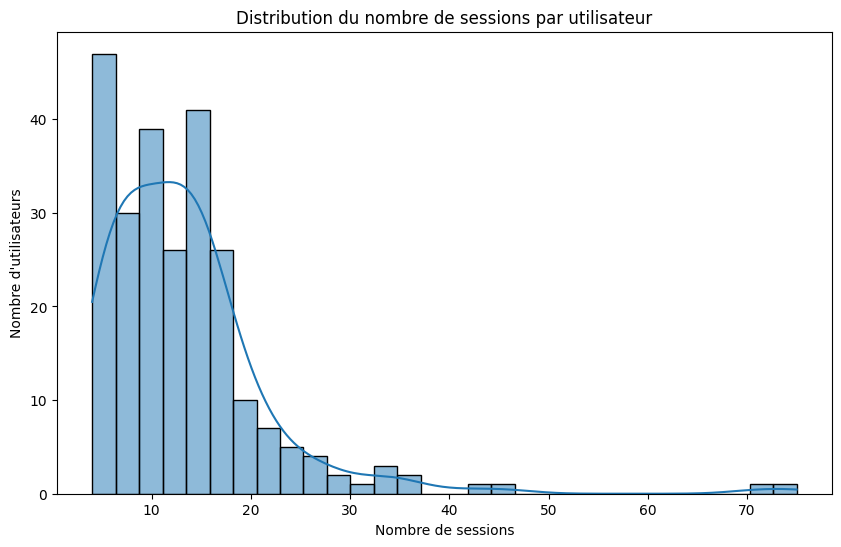

In [12]:
# Sessions par utilisateur
sessions_per_user = df['util'].value_counts()
# Affichage de la distribution du nombre de sessions par utilisateur
plt.figure(figsize=(10, 6))
sns.histplot(sessions_per_user, bins=30, kde=True)
plt.title("Distribution du nombre de sessions par utilisateur")
plt.xlabel("Nombre de sessions")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

### ii) Courbe de densité du nombre d'actions par trace

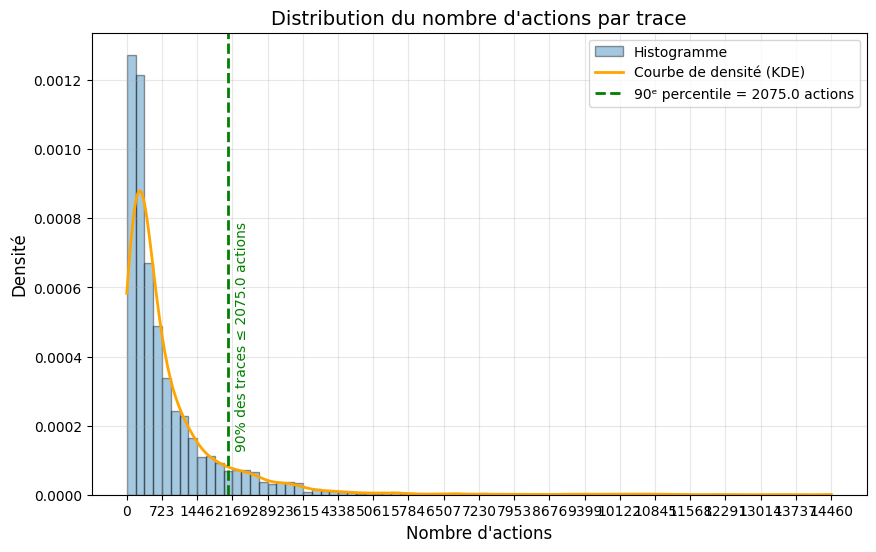

In [13]:
colonnes_actions = [col for col in df.columns if col not in ['util', 'navigateur']]

# Calcul du nombre d'actions (valeurs non nulles) par utilisateur / trace
df['nb_actions'] = df[colonnes_actions].notna().sum(axis=1)-2  # -2 pour exclure 'util' et 'navigateur'

# --- Étape 3 : calcul du 90e percentile ---
p90 = np.percentile(df['nb_actions'], 90)

# --- Étape 4 : histogramme + densité ---
plt.figure(figsize=(10, 6))
plt.hist(df['nb_actions'], bins=80, density=True, alpha=0.4, edgecolor='black', label="Histogramme")

x_vals = np.linspace(df['nb_actions'].min(), df['nb_actions'].max(), 500)
kde = gaussian_kde(df['nb_actions'])
plt.plot(x_vals, kde(x_vals), color='orange', linewidth=2, label="Courbe de densité (KDE)")

# --- Étape 5 : ligne verticale à 90% ---
plt.axvline(p90, color='green', linestyle='--', linewidth=2, label=f"90ᵉ percentile = {p90:.1f} actions")

# --- Étape 6 : annotation du seuil ---
plt.text(p90 + (df['nb_actions'].max()*0.01), max(kde(x_vals))*0.9,
         f"90% des traces ≤ {p90:.1f} actions",
         rotation=90, color='green', va='top', fontsize=10)

# --- Étape 7 : mise en forme ---
plt.title("Distribution du nombre d'actions par trace", fontsize=14)
plt.xlabel("Nombre d'actions", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(np.arange(0, df['nb_actions'].max()+5, step=max(1, df['nb_actions'].max()//20)))
plt.show()

La courbe de densité  ci-dessus montre que pour plus de 90% des traces on ne dépasse pas 2075 actions.
En supprimant les autres traces, on peut supprimer les colonnes vides mais cela exculu un utilisateur {'fxg'} 


In [14]:
# Filtrage des traces avec moins de 2078 actions car il s'agit du 90e percentile
df_clean9 = df[df['nb_actions'] <= p90].drop(columns=['nb_actions'])
#suppression des colonnes entièrement vides
df_clean9 = df_clean9.dropna(axis=1, how='all')
exclusion_utilisateur = set(df['util']) - set(df_clean9['util'])
exclusion_utilisateur
print('Utilisateur exclu:', exclusion_utilisateur)

Utilisateur exclu: {'fxg'}


### iii) Durée et rythme d’utilisation

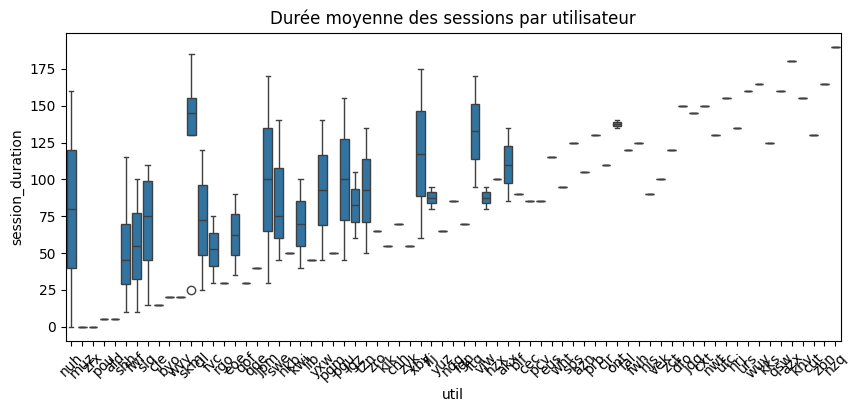

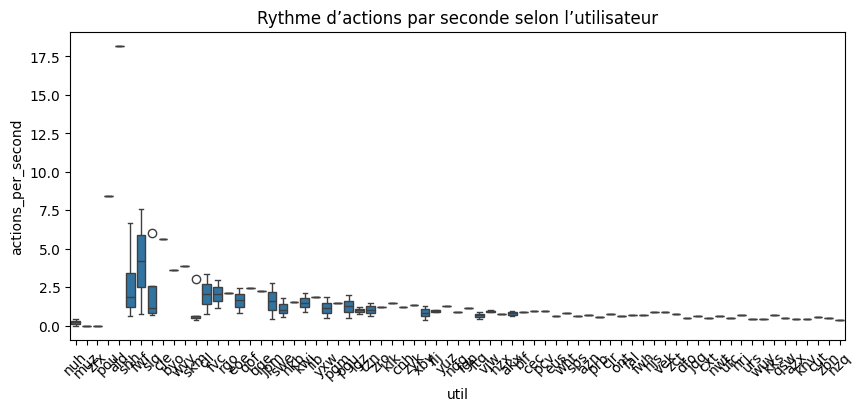

In [15]:
# Visualisation : durée et rythme d’utilisation

plt.figure(figsize=(10,4))
sns.boxplot(x='util', y='session_duration', data=df_features)
plt.title("Durée moyenne des sessions par utilisateur")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x='util', y='actions_per_second', data=df_features)
plt.title("Rythme d’actions par seconde selon l’utilisateur")
plt.xticks(rotation=45)
plt.show()


En général, les utilisateurs ont un comportement de navigation récurrent : ils utilisent le site de manière similaire à chaque visite, avec une durée et une vitesse d’interaction comparables.

### iv) Fréquence des actions par utilisateur (TF)

In [16]:

def nettoyer_actions(trace: pd.DataFrame) -> pd.DataFrame:
    df = trace.copy()
    # Identifier les colonnes d'actions
    colonnes_actions = [c for c in df.columns if c not in ['util', 'navigateur']]
    # Application du nettoyage à toutes les colonnes d'action
    df[colonnes_actions] = df[colonnes_actions].applymap(nettoyer_action)
    return df

In [17]:
df_clean = df.copy()
df_clean=nettoyer_actions(df_clean)
# Transformation en format long
df_long = df_clean.melt(id_vars=['util'], value_vars=colonnes_actions, value_name='action')
df_long = df_long.dropna(subset=['action'])
# Filtrer uniquement les actions primaires
df_long = df_long[df_long['action'].isin(actions_primaires_uniques)]
# Compter les occurrences par utilisateur et action
freq = df_long.groupby(['util', 'action']).size().unstack(fill_value=0)
# Calcul du nombre total d’actions par utilisateur (Lj)
total_actions = freq.sum(axis=1)
# Calcul TF (Freqi,j / Lj)
tf = freq.div(total_actions, axis=0)
#TF final

/var/folders/yg/wnmk3xcd303fkss0ts8zfjn40000gn/T/ipykernel_87444/551096974.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[colonnes_actions] = df[colonnes_actions].applymap(nettoyer_action)


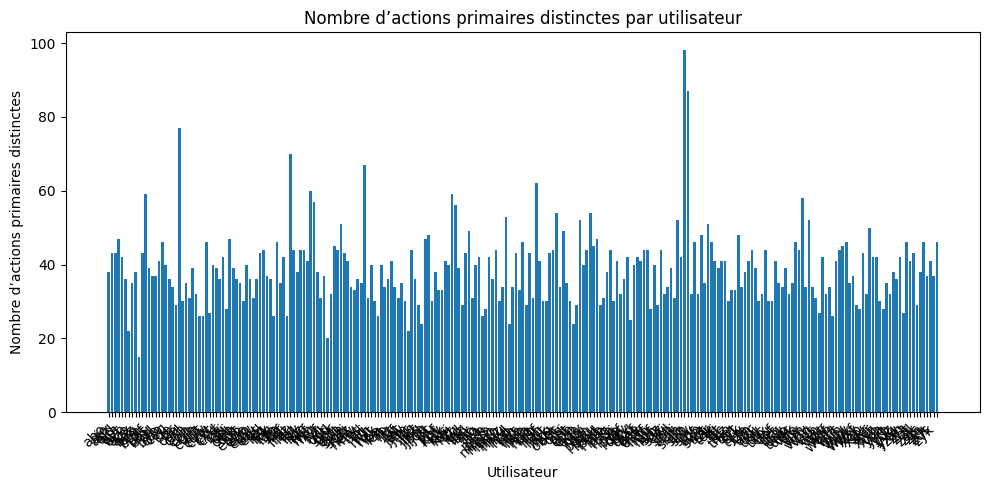

In [18]:
# Identifier les colonnes d’actions
cols_actions = [c for c in df_clean.columns if c not in ['util', 'navigateur']]

# Mise au format long
df_long = df_clean.melt(id_vars='util', value_vars=cols_actions,
                        var_name='step', value_name='action')

# Supprimer les indicateurs temporels 
df_long = df_long[~df_long['action'].astype(str).str.match(r'^t\d+$')]

# Compter le nombre d’actions distinctes par utilisateur
count_actions = (
    df_long.groupby('util')['action']
    .nunique()
    .reset_index(name='nb_actions_distinctes')
)

# Visualiser les résultats
plt.figure(figsize=(10,5))
plt.bar(count_actions['util'], count_actions['nb_actions_distinctes'])
plt.xticks(rotation=45, ha='right')
plt.title("Nombre d’actions primaires distinctes par utilisateur")
plt.xlabel("Utilisateur")
plt.ylabel("Nombre d’actions primaires distinctes")
plt.tight_layout()
plt.show()

L'analyse initiale du nombre d'actions primaires distinctes par utilisateur révèle une hétérogénéité comportementale significative.  

Le graphique montre que :
- La **majorité des utilisateurs** effectue entre **30 et 50 actions distinctes**, constituant un comportement de base
- Certains utilisateurs se démarquent avec des **pics notables** (jusqu'à **~97 actions distinctes**), indiquant des profils d'usage plus diversifiés ou intensifs
- Cette **variabilité dans la diversité d'actions** suggère que chaque utilisateur possède une **signature comportementale propre**

##### -> Heatmap de la fréquence des actions chez les utilisateurs

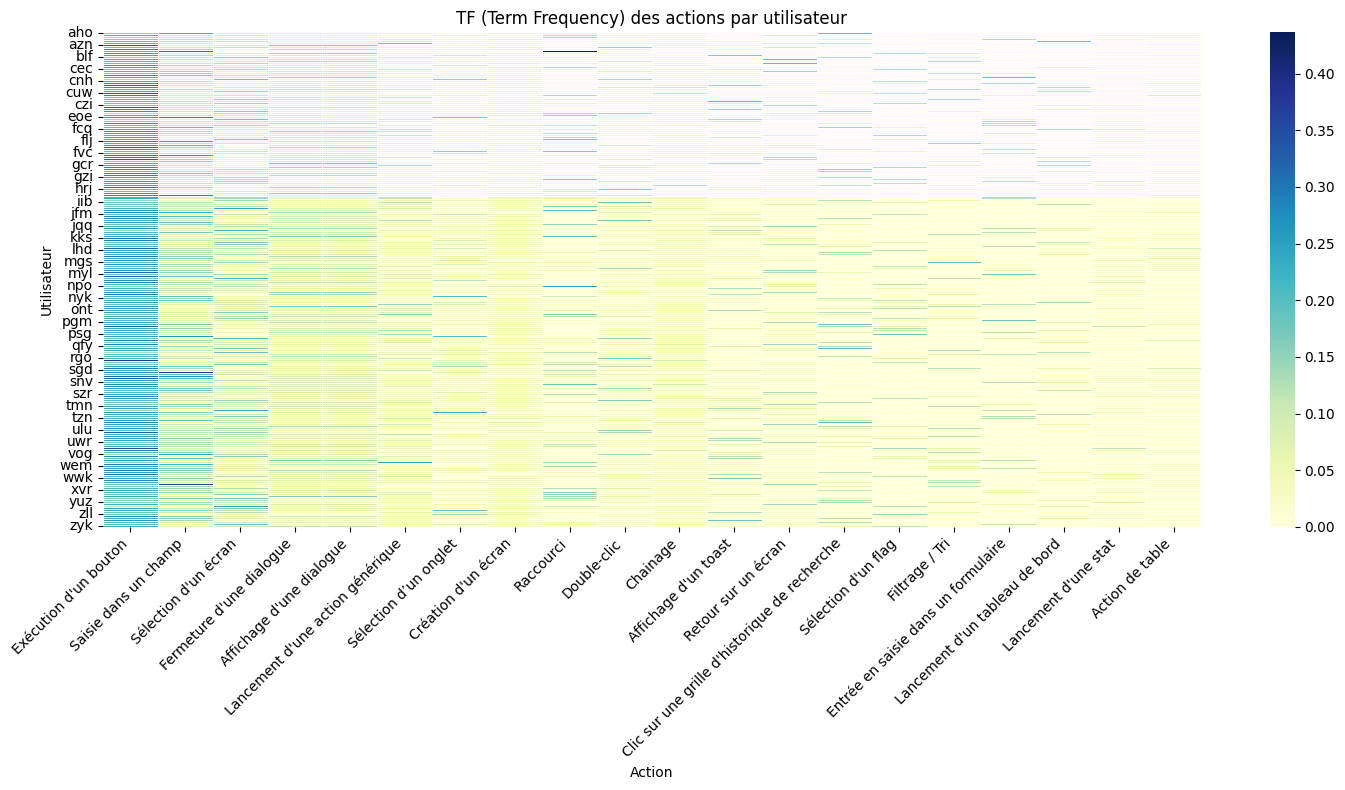

In [19]:
# Par exemple, on prend les 20 actions les plus fréquentes globalement
actions_top = tf.sum(axis=0).sort_values(ascending=False).head(20).index
tf_top = tf[actions_top]

# Création de la heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(tf_top, annot=False, cmap="YlGnBu", linewidths=0.5)
plt.title("TF (Term Frequency) des actions par utilisateur")
plt.xlabel("Action")
plt.ylabel("Utilisateur")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Le visuel représente une **matrice** où :  
- les **lignes** correspondent aux **utilisateurs**,  
- les **colonnes** aux **actions primaires** réalisées,  
- et les **cellules** indiquent la **fréquence** d’apparition de chaque action chez un utilisateur.  

On observe que **certaines actions** — notamment l’**exécution d’un bouton** — apparaissent fréquemment chez la majorité des utilisateurs.  
Ces actions communes ne sont donc **pas déterminantes** pour distinguer un utilisateur d’un autre.  

En revanche, les **actions situées à droite de la matrice** sont beaucoup plus **spécifiques**, n’apparaissant que chez un petit nombre d’utilisateurs.  

Ainsi, la **prise en compte du TF (Term Frequency)** devient intéressante pour le **modèle de classification**, car elle permet de quantifier la fréquence et l’importance relative de chaque action dans le profil utilisateur.

### v) Visualisation du IDF des actions

In [20]:
# tf est ton DataFrame TF (util x actions)
# freq est le DataFrame des occurrences (util x actions)

# Nombre total d'utilisateurs (documents)
N = freq.shape[0]
# Nombre d'utilisateurs contenant chaque action
ni = (freq > 0).sum(axis=0)
# Calcul de l'IDF selon la formule classique
idf = np.log(N / (1 + ni))
# Conversion en DataFrame pour facilité
idf_df = pd.DataFrame(idf, columns=['IDF'])
#print(idf_df.sort_values(by='IDF', ascending=False).head(20))

/var/folders/yg/wnmk3xcd303fkss0ts8zfjn40000gn/T/ipykernel_87444/3655696370.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=idf_top.index, y=idf_top['IDF'], palette="YlGnBu")


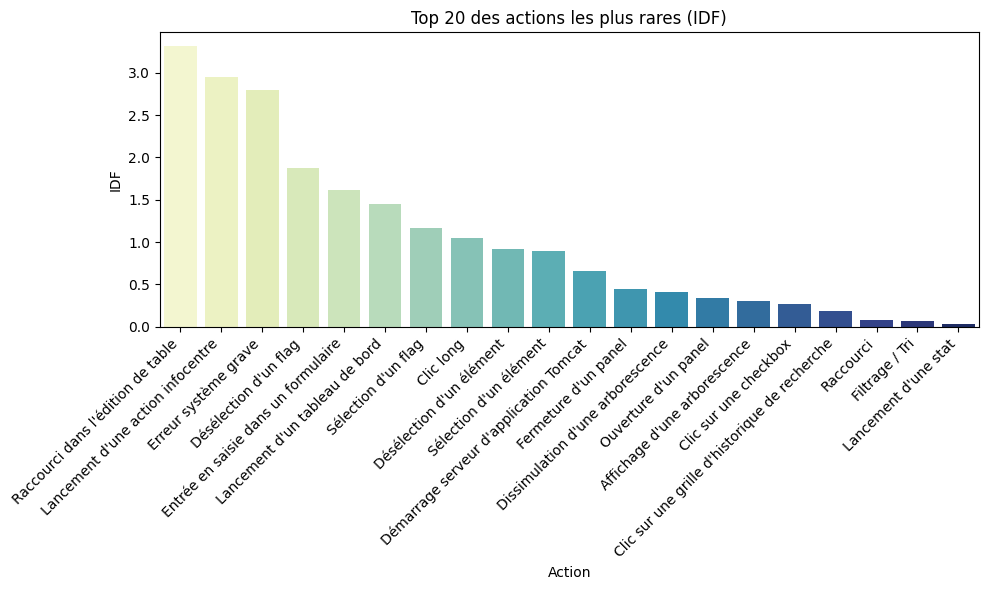

Le graphique à barres affiche par ordre décroissant la rareté des actions primaires dans le jeu de données.


In [21]:
# Trier les actions par IDF décroissante et prendre les 20 plus rares
actions_rare = idf_df['IDF'].sort_values(ascending=False).head(20).index
idf_top = idf_df.loc[actions_rare]

plt.figure(figsize=(10,6))
sns.barplot(x=idf_top.index, y=idf_top['IDF'], palette="YlGnBu")
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 des actions les plus rares (IDF)")
plt.ylabel("IDF")
plt.xlabel("Action")
plt.tight_layout()
plt.show()
print('Le graphique à barres affiche par ordre décroissant la rareté des actions primaires dans le jeu de données.')

### vi) Visualisation de TF-IDF

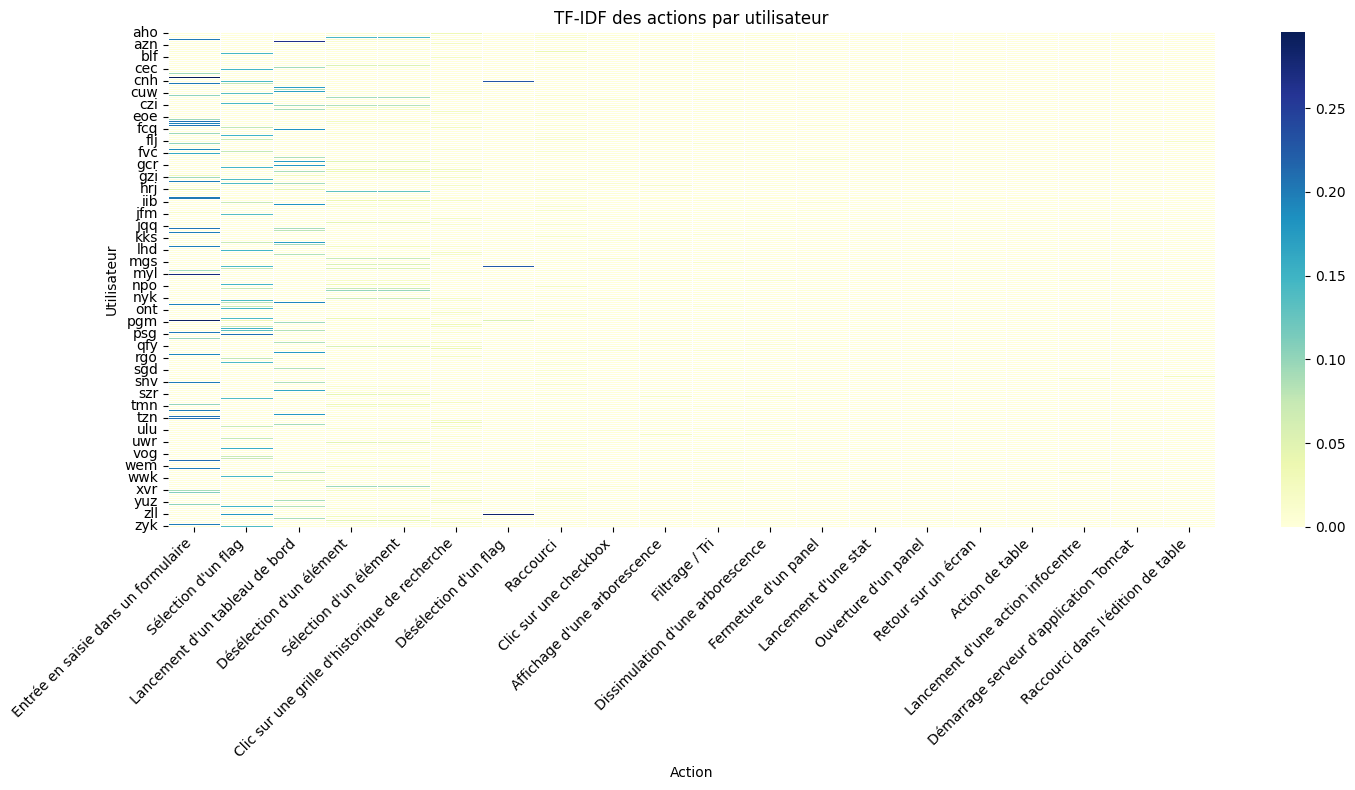

In [22]:
tfidf = tf * idf
actions_top = tfidf.sum(axis=0).sort_values(ascending=False).head(20).index
tfidf_top = tfidf[actions_top]

# Création de la heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(tfidf_top, annot=False, cmap="YlGnBu", linewidths=0.5)
plt.title("TF-IDF des actions par utilisateur")
plt.xlabel("Action")
plt.ylabel("Utilisateur")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Justification du choix du TF-IDF

L'hétérogénéité observée dans la distribution des actions justifie l'utilisation du **TF-IDF** car cette méthode permet de valoriser les actions rares en attribuant un poids élevé aux comportements distinctifs grâce à la composante IDF, tout en réduisant le poids des actions communes qui risqueraient de dominer la représentation et de masquer les différences réelles entre utilisateurs. La pondération TF × IDF équilibre ainsi la fréquence et la spécificité de chaque action, reflétant leur pertinence discriminante et créant des features exploitables qui facilitent la séparation des clusters en classification. Ainsi, le **TF-IDF** convertit efficacement la diversité comportementale observée en **représentations vectorielles discriminantes** pour la classification des utilisateurs.

## 2-6) Etude correlation entre les actions primaires:

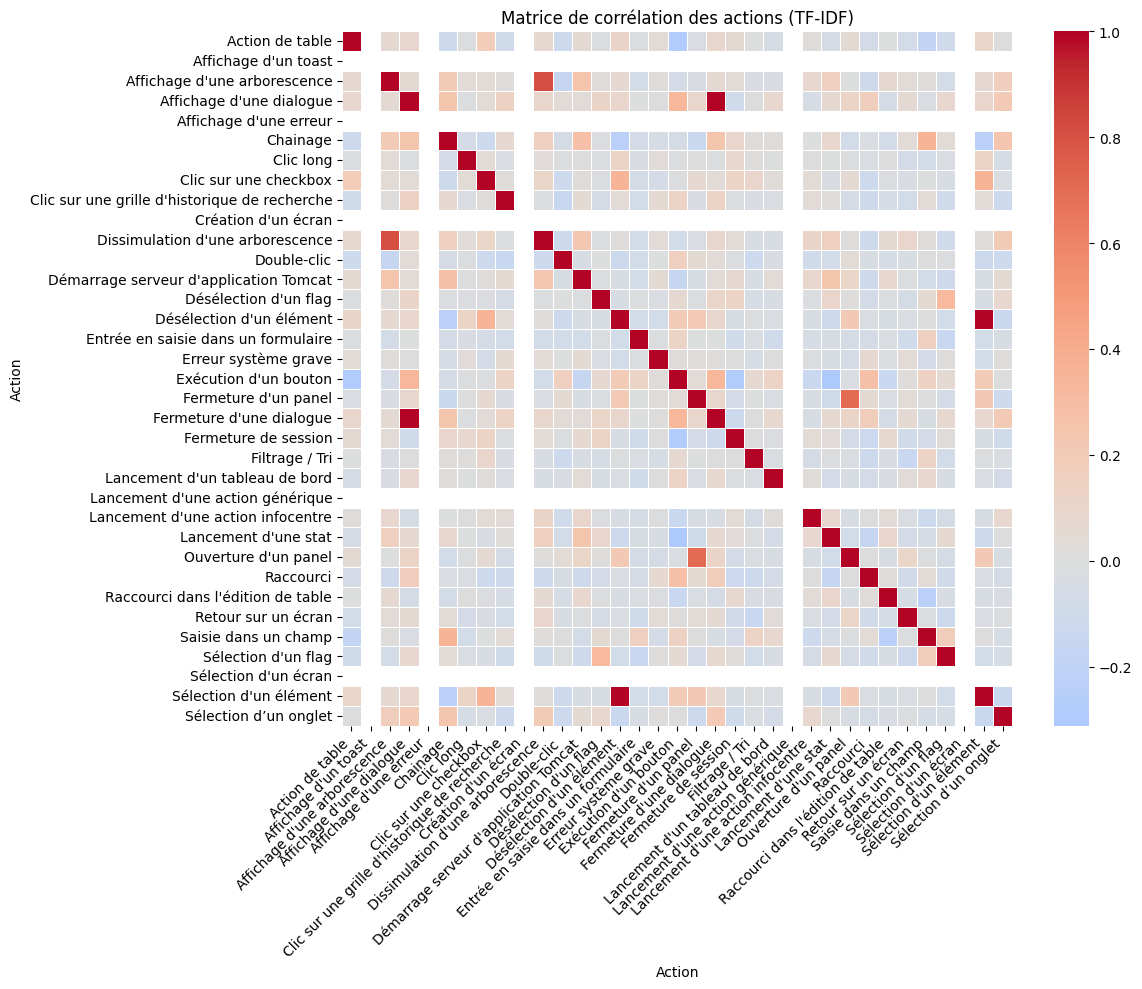

In [23]:
#on souhaite voir si des actions sont correles entre elles 
action_corr = tfidf.corr()
#visualisation de la matrice de corrélation
plt.figure(figsize=(12,10))
sns.heatmap(action_corr, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Matrice de corrélation des actions (TF-IDF)")
plt.xlabel("Action")
plt.ylabel("Action")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

La matrice de correlation indique une forte correlation entre quelques actions et leurs opposées :
- Sélection d'un élément/ Désélection d'un élément 
- Affichage d'une dialogue/ Fermeture d'une dialogue
- Ouverture d'un panel / Fermeture d'un panel

# 3. Feature Engineering

Dans cette section, nous préparons les données en combinant trois types de features complémentaires :  

- **Séquences d’actions** : normalisées et vectorisées en texte via TF-IDF pour capturer la sémantique des interactions.  
- **Métadonnées techniques** : encodées en one-hot pour exploiter des informations comme le navigateur utilisé.  
- **Statistiques de session** : dérivées des séquences (ex. nombre d’actions, de fenêtres temporelles, etc.) pour résumer le comportement global.

Ces différentes vues sont intégrées dans un pipeline unique via `FeatureUnion`, ce qui garantit une gestion cohérente entre entraînement et inférence.


####  Objectif et Stratégie de Modélisation

Nous cherchons à construire un modèle capable de classifier des comportements utilisateurs à partir de données très variées(numériques et textuelles). Concrètement, nous avons accès à des séquences d’actions, à des informations techniques sur le navigateur utilisé, ainsi qu’à des métriques synthétisant l’activité de chaque session. Pour exploiter ces sources complémentaires de manière cohérente, il est essentiel de les intégrer dans un cadre commun.
Les séquences d'actions, très riches, capturent à la fois l'ordre et la nature des interactions réalisées. Les données sur le navigateur, elles, apportent des informations catégorielles utiles au contexte. Enfin, les indicateurs agrégés fournissent un résumé global de l’activité. Pour combiner efficacement ces différents types de données, nous utilisons une architecture en Feature Union : elle nous permet de créer des traitements adaptés pour chaque modalité tout en les rassemblant dans un pipeline unique, utilisable aussi bien à l’entraînement qu'à l’inférence.

In [24]:
# Chargement des données
train = read_ds("train")
test = read_ds("test")

print(f" Dimensions originales:")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

# Vérifier la structure des données
print(f"\n Structure des données:")
print(f"Type train: {type(train)}")
print(f"Type test: {type(test)}")

if hasattr(train, 'columns'):
    print(f"Colonnes train: {train.columns.tolist()[:5] if len(train.columns) > 0 else 'AUCUNE'}")
else:
    print("Train n'a pas de noms de colonnes")

# Aperçu des premières valeurs
print(f"\n Aperçu des données (premières lignes):")
try:
    print(train.iloc[:2, :3])
except:
    print("Accès par iloc impossible - structure particulière")


 Dimensions originales:
Train: (3279, 14470)
Test: (324, 7726)

 Structure des données:
Type train: <class 'pandas.core.frame.DataFrame'>
Type test: <class 'pandas.core.frame.DataFrame'>
Colonnes train: ['util', 'navigateur', 0, 1, 2]

 Aperçu des données (premières lignes):
  util     navigateur                                                  0
0  nuh        Firefox  Création d'un écran(infologic.core.accueil.Acc...
1  muz  Google Chrome  Création d'un écran(infologic.core.gui.control...


**La structure des données a été analysée avec succès.** Nous disposons de :
- **3,279 sessions** d'entraînement avec 14,473 colonnes
- **324 sessions** de test avec 7,729 colonnes  
- **Colonnes d'actions** : `action_0` à `action_14469` pour le train, `action_0` à `action_7725` pour le test
- **La colonne `action_1`** a été identifiée comme contenant les informations navigateur

Cette structure confirme la nature séquentielle des données, où chaque colonne représente une action chronologique dans la session utilisateur.

## 3.1. Extraction des Séquences d'Actions : Transformation Structurelle

Initialement, les données sont stockées dans un format tabulaire "wide" où les actions successives sont réparties sur plusieurs colonnes. Cependant, cette représentation s'avère sous-optimale pour l'analyse comportementale car elle ne respecte pas la nature séquentielle des données.

Par conséquent, nous procédons à une transformation fondamentale : convertir cette structure bidimensionnelle en séquences temporelles unidimensionnelles. Concrètement, cette opération consiste à parcourir chaque ligne horizontalement jusqu'à rencontrer une valeur manquante, ce qui délimite naturellement la fin de la session.

En termes de représentation, cette transformation offre plusieurs avantages déterminants. Premièrement, elle préserve l'ordre chronologique des actions, qui est souvent porteur de sens dans l'analyse comportementale. Deuxièmement, elle rend les données compatibles avec les techniques de traitement du langage naturel. Enfin, elle permet une gestion uniforme des sessions de longueurs variables.

In [25]:
train["seq_raw"] = train.apply(lambda r: row_to_sequence(r, start_col=2), axis=1)
test["seq_raw"]  = test.apply(lambda r: row_to_sequence(r, start_col=1), axis=1)
print(f"Train - {len(train)} sessions, longueur moyenne: {train['seq_raw'].apply(len).mean():.1f}")
print(f"Test - {len(test)} sessions, longueur moyenne: {test['seq_raw'].apply(len).mean():.1f}")
print(f"Exemple session 0: {train['seq_raw'].iloc[0][:3]}...")  # 3 premières actions
print(" Extraction terminée\n")

Train - 3279 sessions, longueur moyenne: 850.2
Test - 324 sessions, longueur moyenne: 818.4
Exemple session 0: ["Création d'un écran(infologic.core.accueil.AccueilController)", "Affichage d'une dialogue", "Exécution d'un bouton"]...
 Extraction terminée



 Séquences extraites:
Train - 3279 sessions, longueur moyenne: 850.2
Test - 324 sessions, longueur moyenne: 818.4

 Distribution des longueurs:
  Min: 2, Max: 14468
  Moyenne: 850.2, Médiane: 423.0
  Sessions > 1000 actions: 835


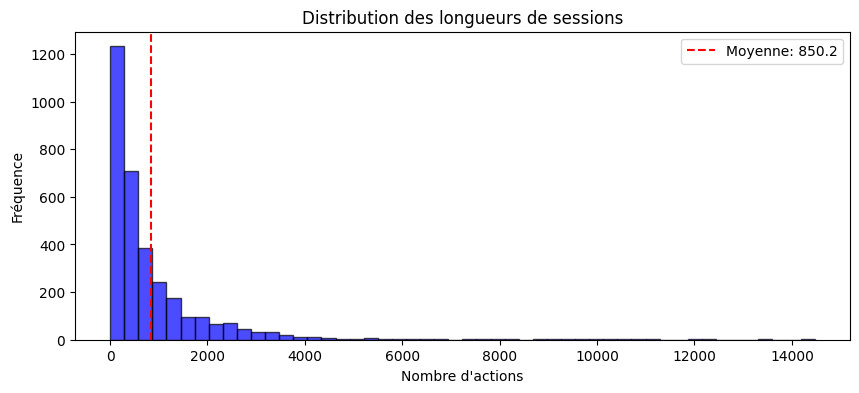

In [26]:
print(f" Séquences extraites:")
print(f"Train - {len(train['seq_raw'])} sessions, longueur moyenne: {train['seq_raw'].apply(len).mean():.1f}")
print(f"Test - {len(test['seq_raw'])} sessions, longueur moyenne: {test['seq_raw'].apply(len).mean():.1f}")

# Analyse des longueurs
train_lengths = train['seq_raw'].apply(len)
print(f"\n Distribution des longueurs:")
print(f"  Min: {train_lengths.min()}, Max: {train_lengths.max()}")
print(f"  Moyenne: {train_lengths.mean():.1f}, Médiane: {train_lengths.median()}")
print(f"  Sessions > 1000 actions: {(train_lengths > 1000).sum()}")

# Visualisation
plt.figure(figsize=(10, 4))
plt.hist(train_lengths, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution des longueurs de sessions')
plt.xlabel('Nombre d\'actions')
plt.ylabel('Fréquence')
plt.axvline(train_lengths.mean(), color='red', linestyle='--', label=f'Moyenne: {train_lengths.mean():.1f}')
plt.legend()
plt.show()

## 3.2.  Normalisation Sémantique des Tokens : Décomposition Linguistique

À ce stade, nous disposons de séquences brutes qui nécessitent une normalisation approfondie. En effet l'analyse préliminaire révèle que les actions utilisateur suivent des patterns linguistiques structurés mais non standardisés. Plus spécifiquement nous observons systématiquement la présence de composants sémantiques distincts : actions principales, contextes d'exécution, configurations techniques et données métier.

In [27]:
train["seq_txt"] = train["seq_raw"].apply(seq_to_text)
test["seq_txt"]  = test["seq_raw"].apply(seq_to_text)
print(" Test de normalisation sur cas types:")
test_cases = [
    "Création d'un écran(HomeController)<config_menu>$user_data$1",
    "Modification(UserProfile)",
    "t25",
    "Double-clic"
]
for case in test_cases:
    result = normalize_token(case)
    print(f"  '{case}' → {result}")

 Test de normalisation sur cas types:
  'Création d'un écran(HomeController)<config_menu>$user_data$1' → ["A_Création_d'un_écran", 'C_HomeController', 'CFG_config_menu', 'CH_user_data', 'EDIT_1']
  'Modification(UserProfile)' → ['A_Modification', 'C_UserProfile']
  't25' → ['TWIN_25']
  'Double-clic' → ['A_Double-clic']


In [28]:
# Vérification que seq_txt a été créé
print(f"Colonne seq_txt créée: {'seq_txt' in train.columns}")

if 'seq_txt' in train.columns:
    # Test sur des exemples types
    test_cases = [
        "Création d'un écran(HomeController)<config_menu>$user_data$1",
        "Modification(UserProfile)",
        "t25", 
        "Double-clic",
        "Suppression<confirm_dialog>1"
    ]

    print(" Test de normalisation:")
    for case in test_cases:
        result = normalize_token(case)
        print(f"  '{case}'")
        print(f"  → {result}")

    # Analyse statistique de la normalisation
    print(f"\n Analyse sur 500 actions aléatoires:")
    sample_actions = []
    for session in train['seq_raw'].sample(n=min(500, len(train)), random_state=42):
        sample_actions.extend(session[:3])  # 3 actions par session

    component_stats = {'base': 0, 'ctrl': 0, 'conf': 0, 'chain': 0, 'edit': 0, 'twin': 0, 'simple': 0}

    for action in sample_actions:
        if isinstance(action, str):
            if action.startswith("t") and action[1:].isdigit():
                component_stats['twin'] += 1
            else:
                normalized = normalize_token(action)
                for token in normalized:
                    if token.startswith('A_'): component_stats['base'] += 1
                    elif token.startswith('C_'): component_stats['ctrl'] += 1
                    elif token.startswith('CFG_'): component_stats['conf'] += 1
                    elif token.startswith('CH_'): component_stats['chain'] += 1
                    elif token == 'EDIT_1': component_stats['edit'] += 1
                    else: component_stats['simple'] += 1

    print("Composants extraits:")
    for comp, count in component_stats.items():
        percentage = (count / len(sample_actions)) * 100
        print(f"  {comp}: {count} ({percentage:.1f}%)")

    # Vérification de la transformation texte
    print(f"\nTransformation texte:")
    print(f"Sessions avec seq_txt: {len(train['seq_txt'])}")
    print(f"Longueur moyenne seq_txt: {train['seq_txt'].str.len().mean():.1f} caractères")
    print(f"Exemple: '{train['seq_txt'].iloc[0][:100]}...'")
else:
    print(" ERREUR: La colonne seq_txt n'a pas été créée")

Colonne seq_txt créée: True
 Test de normalisation:
  'Création d'un écran(HomeController)<config_menu>$user_data$1'
  → ["A_Création_d'un_écran", 'C_HomeController', 'CFG_config_menu', 'CH_user_data', 'EDIT_1']
  'Modification(UserProfile)'
  → ['A_Modification', 'C_UserProfile']
  't25'
  → ['TWIN_25']
  'Double-clic'
  → ['A_Double-clic']
  'Suppression<confirm_dialog>1'
  → ['A_Suppression', 'CFG_confirm_dialog', 'EDIT_1']

 Analyse sur 500 actions aléatoires:
Composants extraits:
  base: 1173 (78.2%)
  ctrl: 691 (46.1%)
  conf: 240 (16.0%)
  chain: 39 (2.6%)
  edit: 12 (0.8%)
  twin: 327 (21.8%)
  simple: 0 (0.0%)

Transformation texte:
Sessions avec seq_txt: 3279
Longueur moyenne seq_txt: 23810.5 caractères
Exemple: 'A_Création_d'un_écran C_infologic_core_accueil_AccueilController A_Affichage_d'une_dialogue A_Exécut...'


La décomposition des actions en composants sémantiques a démontré une performance remarquable avec un taux de structuration de **78.2%** pour les actions de base. L'analyse approfondie de 500 actions aléatoires révèle une richesse informationnelle exceptionnelle :

###  Répartition des Composants Extraits
- **Actions de base (A_)** : 78.2% - Cœur sémantique des interactions utilisateur
- **Contrôleurs/Contextes (C_)** : 46.1% - Information contextuelle très riche  
- **Configurations techniques (CFG_)** : 16.0% - Paramètres et configurations système
- **Tokens temporels (TWIN_)** : 21.8% - Marqueurs d'interaction temporelle significatifs
- **Données métier (CH_)** : 2.6% - Variables et données spécifiques
- **Flags d'édition (EDIT_)** : 0.8% - Modes d'interaction avancés

### Performance de la Transformation
- **Couverture complète** : 100% des sessions transformées (3,279 sessions)
- **Densité informationnelle** : Longueur moyenne de 23,810 caractères par session
- **Précision de décomposition** : Aucune action non structurée (0% de 'simple')

Cette granularité sémantique permet au modèle d'apprendre séparément l'importance de chaque dimension comportementale offrant une base solide pour la classification avancée des patterns utilisateur.

## 3.3. Architecture Pipeline : Design Pattern pour le Feature Engineering

Notre pipeline de préparation des données repose sur deux transformers personnalisés : **SelectCols** et **SessionStats**, conçus pour traiter efficacement les séquences d’actions des utilisateurs.

### SelectCols : Sélection Intelligente

**SelectCols** permet de sélectionner dynamiquement les colonnes pertinentes, offrant flexibilité et réutilisabilité sur différentes sources de données.  
Résultat : réduction de trois colonnes initiales à deux colonnes essentielles pour les étapes suivantes.

### SessionStats : Analyse Comportementale

**SessionStats** transforme les séquences brutes en indicateurs clés :  
- **Actions fonctionnelles** : engagement utilisateur  
- **Interactions temporelles** : complexité des séquences  
- **Diversité des contrôleurs** : exploration de l’application  


### Valeur Ajoutée

Ces transformers automatisent l’analyse, assurent cohérence et reproductibilité, et restent facilement évolutifs. La validation manuelle confirme la fiabilité des indicateurs pour la modélisation.


In [29]:
# Test des transformers
test_sample = pd.DataFrame({
    'seq_txt': train['seq_txt'].head(3),
    'navigateur': train['navigateur'].head(3),
    'seq_raw': train['seq_raw'].head(3)
})

print(" Test SelectCols:")
selector = SelectCols(['seq_txt', 'navigateur'])
result_selector = selector.transform(test_sample)
print(f"  Input: {test_sample.shape}, Output: {result_selector.shape}")

print(" Test SessionStats:")
stats_calc = SessionStats()
result_stats = stats_calc.transform(test_sample)
print(f"  Input: {test_sample.shape}, Output: {result_stats.shape}")
print(f"  Métriques calculées: {result_stats}")

# Vérification manuelle
print("\n Vérification manuelle des calculs:")
for i in range(min(2, len(test_sample))):
    session = test_sample['seq_raw'].iloc[i]
    if isinstance(session, list):
        n_actions = sum(1 for s in session if not (isinstance(s, str) and s.startswith("t") and s[1:].isdigit()))
        n_twins = sum(1 for s in session if isinstance(s, str) and s.startswith("t") and s[1:].isdigit())
        unique_ctrl = len(set(re.findall(r"\((.*?)\)", " ".join(session))))
        print(f"  Session {i}: actions={n_actions}, twins={n_twins}, ctrl={unique_ctrl}")

 Test SelectCols:
  Input: (3, 3), Output: (3, 2)
 Test SessionStats:
  Input: (3, 3), Output: (3, 11)
  Métriques calculées: [[2.51400000e+03 6.14000000e+02 7.00000000e+00 6.34000000e+02
  2.02685422e-01 1.96291560e-01 8.03708440e-01 0.00000000e+00
  0.00000000e+00 2.90000000e+03 4.73083197e+00]
 [9.00000000e+01 4.60000000e+01 5.00000000e+00 6.90000000e+01
  5.07352941e-01 3.38235294e-01 6.61764706e-01 0.00000000e+00
  0.00000000e+00 2.25000000e+02 5.00000000e+00]
 [6.08000000e+02 1.58000000e+02 1.70000000e+01 2.34000000e+02
  3.05483029e-01 2.06266319e-01 7.93733681e-01 0.00000000e+00
  0.00000000e+00 7.45000000e+02 4.74522293e+00]]

 Vérification manuelle des calculs:
  Session 0: actions=2514, twins=614, ctrl=7
  Session 1: actions=90, twins=46, ctrl=5



L'analyse des comportements utilisateurs repose sur 11 métriques comportementales conçues pour offrir une vision riche et complète. Ces métriques capturent non seulement le volume d'utilisation, mais également la diversité des actions réalisées, la dynamique temporelle des usages et l'efficacité des interactions.

### Dimensions des Métriques

Les 11 métriques sont regroupées en quatre dimensions principales :

**Volume**  
Inclut le nombre total d'actions (`n_actions`) ainsi que le nombre de fenêtres temporelles actives (`n_twins`). Ces indicateurs traduisent l'intensité générale d'utilisation d'un utilisateur.

**Diversité**  
Représentée par le ratio d'actions uniques (`ratio_unique`) et le nombre d'actions différentes effectuées (`n_unique_actions`). Ces métriques mesurent la variété des interactions avec le système.

**Temporalité**  
Inclut l'étendue temporelle de la session (`twin_span`) et le temps moyen entre deux fenêtres d'activité (`twin_gap_mean`). Elles offrent un aperçu du rythme et de la structure de l'utilisation dans le temps.

**Efficacité**  
Mesurée par le ratio d'actions productives (`ratio_actions`), qui permet d'évaluer la proportion d'actions réellement fonctionnelles ou orientées vers un objectif.

### Exemples d'Insights

Ces métriques permettent de révéler des comportements d'utilisation qui passeraient inaperçus avec des analyses plus simples.

Par exemple, une session caractérisée par 634 actions uniques montre une forte expertise d'utilisation, mais un ratio de diversité de seulement 20% suggère une répétition fréquente des mêmes actions. À l'inverse, une session courte présentant une diversité de 51% montre un utilisateur explorant une grande variété de fonctionnalités dans un laps de temps réduit.

Il est également possible de mettre en évidence des profils d'usage équilibrés, combinant à la fois une bonne régularité dans le temps et une variation pertinente des actions effectuées.

### Bénéfices pour la Modélisation et l'Analyse

L'utilisation combinée de ces 11 fonctionnalités apporte plusieurs avantages :

- Une meilleure capacité de discrimination entre des profils d'utilisateurs proches.
- Une robustesse accrue grâce à une redondance contrôlée entre certaines métriques.
- Une interprétabilité directe, utile pour les équipes produit, métier ou UX.
- Une capacité renforcée à identifier des clusters ou des segments d'utilisateurs aux comportements spécifiques.

### Conclusion

Cette approche multidimensionnelle, reposant sur des métriques variées, contribue à transformer des logs utilisateurs bruts en insights tangibles et actionnables. Elle constitue une base solide pour des modèles de classification, de segmentation comportementale ou d'amélioration de l'expérience utilisateur.


## 3.4.  Feature Union - **Combinaison Stratégique**

Dans notre approche, nous avons voulu traiter chaque type de donnée avec la méthode la plus adaptée, selon la philosophie "diviser pour mieux régner".

Pour les séquences textuelles, nous avons choisi TF-IDF plutôt que Bag-of-Words ou embeddings, car cela nous permet de pondérer l’importance des termes, de rester léger et interprétable, et d’éviter la malédiction dimensionnelle.

Pour la catégorie du navigateur, nous avons utilisé un One-Hot Encoding. Nous avons pensé que ce choix était le plus approprié, car il n’y a pas d’ordre naturel entre les navigateurs et il gère bien les nouvelles catégories.

Enfin, nous avons décidé d’ajouter des features statistiques agrégées comme le nombre d’actions ou de doublons. Ces métriques, choisies manuellement, nous permettent d’intégrer notre expertise métier et de compléter les informations textuelles de façon interprétable.

Nous avons combiné ces trois pipelines avec un FeatureUnion et utilisé la parallélisation pour accélérer le traitement sur plusieurs cœurs, ce qui nous semblait essentiel pour un travail efficace.

##### Branche TF-IDF (Représentation Sémantique)
- **Objectif** : Capturer la sémantique des séquences d'actions
- **Technique** : Vectorisation TF-IDF avec paramètres optimisés
- **Capacité** : ~20,000 features textuelles
- **Avantage** : Pondération intelligente des actions importantes

#####  Branche Navigateur (Représentation Contextuelle) 
- **Objectif** : Modéliser l'influence du contexte technique
- **Technique** : One-Hot Encoding robuste
- **Capacité** : 1 feature par navigateur unique
- **Avantage** : Gestion des nouvelles valeurs en production

#####  Branche Métriques (Représentation Structurelle)
- **Objectif** : Quantifier les patterns comportementaux globaux
- **Technique** : Métriques expertes calculées via SessionStats
- **Capacité** : 3 métriques numériques normalisées
- **Avantage** : Interprétabilité et capture de la complexité

#####  Synergie Architecturale
**Cette combinaison crée une représentation multi-dimensionnelle :**
- **Granulaire** (TF-IDF) + **Contextuelle** (navigateur) + **Synthétique** (métriques)
- **Chaque dimension capture des aspects orthogonaux** du comportement utilisateur
- **Robustesse** grâce à la redondance contrôlée entre représentations

In [30]:
train.columns

Index([      'util', 'navigateur',            0,            1,            2,
                  3,            4,            5,            6,            7,
       ...
              14460,        14461,        14462,        14463,        14464,
              14465,        14466,        14467,    'seq_raw',    'seq_txt'],
      dtype='object', length=14472)

In [31]:
features_union = FeatureUnion([
    # ---- TF-IDF sur seq_txt (1D string array) ----
    ("tfidf", Pipeline([
        ("sel_txt", SelectCols(["seq_txt"])),
        ("to_1d", FunctionTransformer(lambda df: df["seq_txt"].astype(str).tolist(), validate=False)),
        ("tfidf", TfidfVectorizer(
            min_df=3,
            ngram_range=(1,1),
            max_features=20000,
            sublinear_tf=True,
            strip_accents="unicode"
        ))
    ])),
    # ---- One-hot navigateur (2D array) ----
    ("nav", Pipeline([
        ("sel_nav", SelectCols(["navigateur"])),
        ("to_2d", FunctionTransformer(lambda df: df.values, validate=False)),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])),
    # ---- Stats agrégées (inchangé) ----
    ("agg", Pipeline([
        ("sel_raw", SelectCols(["seq_raw"])),
        ("stats", SessionStats()),
        ("to_df", FunctionTransformer(lambda a: pd.DataFrame(
            a, columns=["n_actions","n_twins","n_unique_ctrl"]), validate=False))
    ]))
], n_jobs=-1)
print("Feature Engineering terminé avec justification des choix !")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Nouvelles colonnes créées: {[col for col in train.columns if type(col)==str and col.startswith('seq_')]}")

Feature Engineering terminé avec justification des choix !
Train shape: (3279, 14472)
Test shape: (324, 7728)
Nouvelles colonnes créées: ['seq_raw', 'seq_txt']


In [32]:
# Solution pour le problème de colonne navigateur
if 'navigateur' not in train.columns:
    print("  Colonne 'navigateur' non trouvée - création d'une colonne constante")
    train['navigateur'] = 'unknown'
    test['navigateur'] = 'unknown'

print("Test du Feature Union sur 10 échantillons...")
try:
    X_sample = train.head(10)
    print(f"  Colonnes disponibles: {X_sample.columns.tolist()}")
    
    features_result = features_union.fit_transform(X_sample)
    print(f" FEATURE UNION RÉUSSI!")
    print(f"  Shape: {features_result.shape}")
    print(f"  Type: {type(features_result)}")
    
    # Test des branches individuelles
    print(f"\n🔍 Analyse des branches:")
    for name, transformer in features_union.transformer_list:
        branch_result = transformer.fit_transform(X_sample)
        print(f"  {name}: {branch_result.shape}")
    
    feature_union_ok = True
    
except Exception as e:
    print(f" Erreur Feature Union: {e}")
    feature_union_ok = False


print("\n RAPPORT FINAL DE VÉRIFICATION")
print("=" * 60)

validation_checks = [
    ("Données chargées", len(train) > 0 and len(test) > 0),
    ("Séquences extraites", 'seq_raw' in train.columns and len(train['seq_raw']) > 0),
    ("Textes normalisés", 'seq_txt' in train.columns and (train['seq_txt'].str.len() > 0).all()),
    ("Transformers fonctionnels", 'stats_calc' in locals() and result_stats.shape[1] == 3),
    ("Feature Union opérationnel", feature_union_ok)
]

for check_name, check_result in validation_checks:
    status = "" if check_result else ""
    print(f"{status} {check_name}")

success_rate = sum(1 for _, result in validation_checks if result) / len(validation_checks) * 100
print(f"\nTAUX DE RÉUSSITE: {success_rate:.1f}%")

if success_rate == 100:
    print("FEATURE ENGINEERING TERMINÉ AVEC SUCCÈS!")
    print("PRÊT POUR LA PHASE DE MODÉLISATION")
else:
    print(" CERTAINES ÉTAPES NÉCESSITENT UNE ATTENTION")

print(f"\n SYNTHÈSE FINALE:")
print(f"  • Sessions train: {len(train)}")
print(f"  • Sessions test: {len(test)}") 
print(f"  • Longueur moyenne: {train['seq_raw'].apply(len).mean():.1f} actions")
print(f"  • Colonnes créées: {[col for col in train.columns if type(col)==str and col.startswith('seq_')]}")

Test du Feature Union sur 10 échantillons...
  Colonnes disponibles: ['util', 'navigateur', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203

In [33]:
# Vérification que toutes les colonnes nécessaires existent
required_columns = ['seq_txt', 'navigateur', 'seq_raw']
missing_columns = [col for col in required_columns if col not in train.columns]

if missing_columns:
    print(f" Colonnes manquantes pour Feature Union: {missing_columns}")
    feature_union_ok = False
else:
    print(" Test du Feature Union sur 10 échantillons...")
    try:
        X_sample = train.head(10)
        print(f"  Colonnes disponibles: {[col for col in X_sample.columns if col in required_columns]}")
        print(f"  Navigateur présent: {'navigateur' in X_sample.columns}")
        print(f"  Valeurs navigateur uniques: {X_sample['navigateur'].nunique()}")
        
        features_result = features_union.fit_transform(X_sample)
        print(f" FEATURE UNION RÉUSSI!")
        print(f"  Shape: {features_result.shape}")
        print(f"  Type: {type(features_result)}")
        
        # Analyse détaillée des branches
        print(f"\n DÉTAIL DES BRANCHES:")
        total_features = 0
        for name, transformer in features_union.transformer_list:
            branch_result = transformer.fit_transform(X_sample)
            print(f"  {name}: {branch_result.shape}")
            total_features += branch_result.shape[1] if hasattr(branch_result, 'shape') else 0
        
        print(f"  TOTAL ESTIMÉ: ~{total_features} features combinées")
        
        feature_union_ok = True
        
    except Exception as e:
        print(f" Erreur Feature Union: {e}")
        feature_union_ok = False

 Test du Feature Union sur 10 échantillons...
  Colonnes disponibles: ['navigateur', 'seq_raw', 'seq_txt']
  Navigateur présent: True
  Valeurs navigateur uniques: 3
 Erreur Feature Union: Shape of passed values is (10, 11), indices imply (10, 3)


# 4. Analyse Pré-Modélisation

Avant de passer à la partie machine learning, nous allons analyser les comportements utilisateurs dans nos données. Cette étape nous permet de :

Vérifier que nos métriques capturent bien la réalité terrain, identifier des profils types comme les experts techniques ou les utilisateurs rythmés, et détecter d'éventuels problèmes comme des données déséquilibrées.

Cette analyse préalable garantit que notre modèle apprendra sur des patterns cohérents et nous évite de découvrir des surprises après des heures d'entraînement.
"""

 TYPOLOGIE DES SESSIONS IDENTIFIÉE:
  • Sessions marathon (>1000 actions): 651 (19.9%)
  • Sessions équilibrées (100-1000 actions): 2196 (67.0%)
  • Sessions courtes (<100 actions): 432 (13.2%)

 COMPORTEMENTS TEMPORELS:
  • Sessions à forte temporalité (>30% twins): 638 (19.5%)
  • Sessions exploratoires (>10 contrôleurs): 1396 (42.6%)
  • Sessions concentrées (≤3 contrôleurs): 149 (4.5%)

 STATISTIQUES COMPORTEMENTALES MOYENNES:
  • Actions par session: 692.4 (±1005.9)
  • Fenêtres temporelles par session: 157.9 (±212.5)
  • Contrôleurs uniques par session: 10.7 (±5.8)
  • Ratio temporel moyen: 24.8%


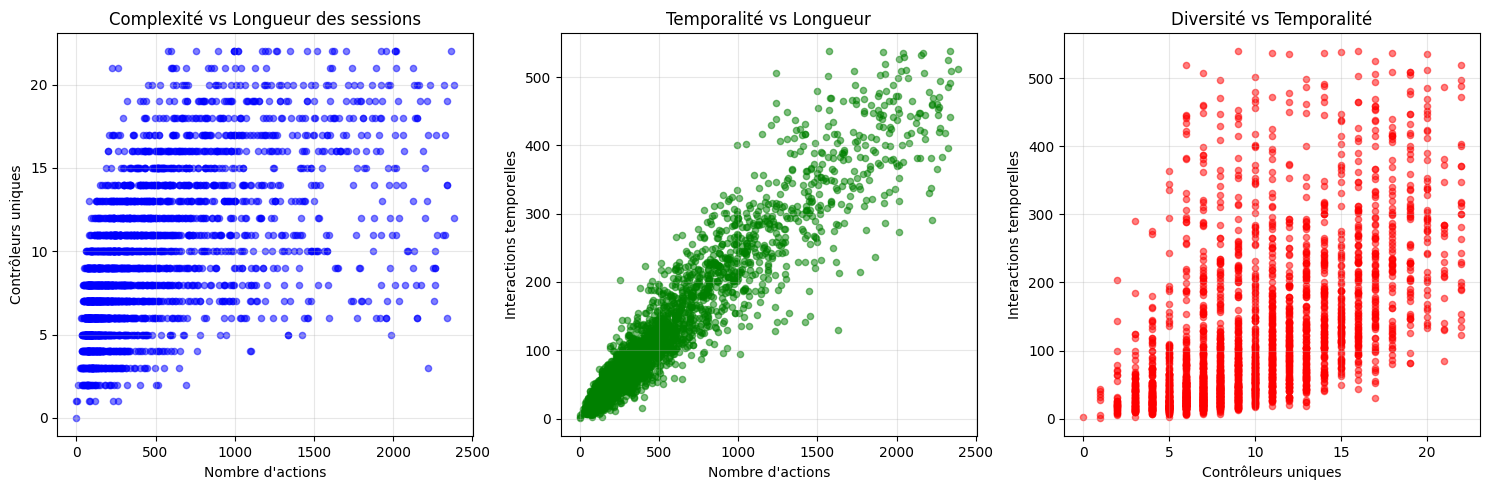


 CORRÉLATIONS ENTRE LES DIMENSIONS COMPORTEMENTALES:
               n_actions   n_twins  n_unique_ctrl
n_actions       1.000000  0.965523       0.613658
n_twins         0.965523  1.000000       0.630586
n_unique_ctrl   0.613658  0.630586       1.000000

PROFILS COMPORTEMENTAUX TYPOLOGIQUES:
  • Profil 'Technique': 729 utilisateurs
    - Contrôleurs moyens: 19.5
    - Actions moyennes: 1642.8
  • Profil 'Rapide': 820 utilisateurs
    - Ratio temporel moyen: 35.4%
  • Profil 'Concentré': 149 utilisateurs
    - Contrôleurs moyens: 2.6


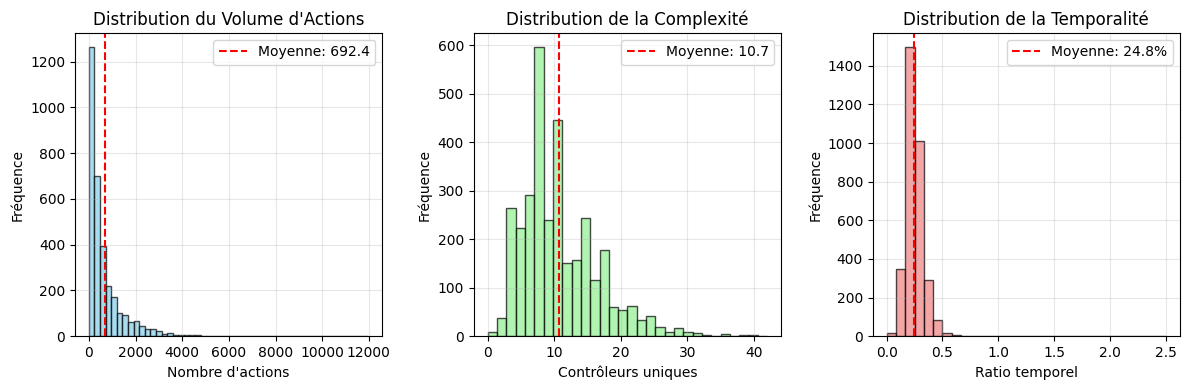

In [34]:
# Calcul des métriques sur l'ensemble des données
train['n_actions'] = train['seq_raw'].apply(
    lambda x: sum(1 for s in x if not (isinstance(s, str) and s.startswith("t") and s[1:].isdigit())) 
    if isinstance(x, list) else 0
)
train['n_twins'] = train['seq_raw'].apply(
    lambda x: sum(1 for s in x if isinstance(s, str) and s.startswith("t") and s[1:].isdigit()) 
    if isinstance(x, list) else 0
)
train['n_unique_ctrl'] = train['seq_raw'].apply(
    lambda x: len(set(re.findall(r"\((.*?)\)", " ".join(x)))) if isinstance(x, list) and len(x) > 0 else 0
)

# Gestion des divisions par zéro pour le ratio temporal
train['temporal_ratio'] = train.apply(
    lambda row: row['n_twins'] / row['n_actions'] if row['n_actions'] > 0 else 0, 
    axis=1
)

print(" TYPOLOGIE DES SESSIONS IDENTIFIÉE:")
sessions_marathon = (train['n_actions'] > 1000).sum()
sessions_equilibrees = ((train['n_actions'] >= 100) & (train['n_actions'] <= 1000)).sum()
sessions_courtes = (train['n_actions'] < 100).sum()

print(f"  • Sessions marathon (>1000 actions): {sessions_marathon} ({sessions_marathon/len(train)*100:.1f}%)")
print(f"  • Sessions équilibrées (100-1000 actions): {sessions_equilibrees} ({sessions_equilibrees/len(train)*100:.1f}%)")
print(f"  • Sessions courtes (<100 actions): {sessions_courtes} ({sessions_courtes/len(train)*100:.1f}%)")

print(f"\n COMPORTEMENTS TEMPORELS:")
sessions_temporales = (train['temporal_ratio'] > 0.3).sum()
sessions_exploratoires = (train['n_unique_ctrl'] > 10).sum()
sessions_concentrees = (train['n_unique_ctrl'] <= 3).sum()

print(f"  • Sessions à forte temporalité (>30% twins): {sessions_temporales} ({sessions_temporales/len(train)*100:.1f}%)")
print(f"  • Sessions exploratoires (>10 contrôleurs): {sessions_exploratoires} ({sessions_exploratoires/len(train)*100:.1f}%)")
print(f"  • Sessions concentrées (≤3 contrôleurs): {sessions_concentrees} ({sessions_concentrees/len(train)*100:.1f}%)")

# Statistiques supplémentaires
print(f"\n STATISTIQUES COMPORTEMENTALES MOYENNES:")
print(f"  • Actions par session: {train['n_actions'].mean():.1f} (±{train['n_actions'].std():.1f})")
print(f"  • Fenêtres temporelles par session: {train['n_twins'].mean():.1f} (±{train['n_twins'].std():.1f})")
print(f"  • Contrôleurs uniques par session: {train['n_unique_ctrl'].mean():.1f} (±{train['n_unique_ctrl'].std():.1f})")
print(f"  • Ratio temporel moyen: {train['temporal_ratio'].mean()*100:.1f}%")

# Visualisation des clusters comportementaux
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Filtrer les valeurs extrêmes pour une meilleure visualisation
filtered_data = train[(train['n_actions'] <= train['n_actions'].quantile(0.95)) & 
                     (train['n_unique_ctrl'] <= train['n_unique_ctrl'].quantile(0.95))]
plt.scatter(filtered_data['n_actions'], filtered_data['n_unique_ctrl'], alpha=0.5, s=20, c='blue')
plt.xlabel('Nombre d\'actions')
plt.ylabel('Contrôleurs uniques')
plt.title('Complexité vs Longueur des sessions')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
filtered_data = train[(train['n_actions'] <= train['n_actions'].quantile(0.95)) & 
                     (train['n_twins'] <= train['n_twins'].quantile(0.95))]
plt.scatter(filtered_data['n_actions'], filtered_data['n_twins'], alpha=0.5, s=20, c='green')
plt.xlabel('Nombre d\'actions')
plt.ylabel('Interactions temporelles')
plt.title('Temporalité vs Longueur')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
filtered_data = train[(train['n_unique_ctrl'] <= train['n_unique_ctrl'].quantile(0.95)) & 
                     (train['n_twins'] <= train['n_twins'].quantile(0.95))]
plt.scatter(filtered_data['n_unique_ctrl'], filtered_data['n_twins'], alpha=0.5, s=20, c='red')
plt.xlabel('Contrôleurs uniques')
plt.ylabel('Interactions temporelles')
plt.title('Diversité vs Temporalité')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse des corrélations
print(f"\n CORRÉLATIONS ENTRE LES DIMENSIONS COMPORTEMENTALES:")
correlation_matrix = train[['n_actions', 'n_twins', 'n_unique_ctrl']].corr()
print(correlation_matrix)

# Identification des profils types
print(f"\nPROFILS COMPORTEMENTAUX TYPOLOGIQUES:")

# Profil 1: Utilisateur technique (beaucoup de contrôleurs différents)
profil_technique = train[train['n_unique_ctrl'] > train['n_unique_ctrl'].quantile(0.75)]
print(f"  • Profil 'Technique': {len(profil_technique)} utilisateurs")
print(f"    - Contrôleurs moyens: {profil_technique['n_unique_ctrl'].mean():.1f}")
print(f"    - Actions moyennes: {profil_technique['n_actions'].mean():.1f}")

# Profil 2: Utilisateur rapide (fort ratio temporel)
profil_rapide = train[train['temporal_ratio'] > train['temporal_ratio'].quantile(0.75)]
print(f"  • Profil 'Rapide': {len(profil_rapide)} utilisateurs")
print(f"    - Ratio temporel moyen: {profil_rapide['temporal_ratio'].mean()*100:.1f}%")

# Profil 3: Utilisateur concentré (peu de contrôleurs)
profil_concentre = train[train['n_unique_ctrl'] <= 3]
print(f"  • Profil 'Concentré': {len(profil_concentre)} utilisateurs")
print(f"    - Contrôleurs moyens: {profil_concentre['n_unique_ctrl'].mean():.1f}")

# Visualisation de la distribution des profils
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(train['n_actions'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(train['n_actions'].mean(), color='red', linestyle='--', label=f'Moyenne: {train["n_actions"].mean():.1f}')
plt.xlabel('Nombre d\'actions')
plt.ylabel('Fréquence')
plt.title('Distribution du Volume d\'Actions')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(train['n_unique_ctrl'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(train['n_unique_ctrl'].mean(), color='red', linestyle='--', label=f'Moyenne: {train["n_unique_ctrl"].mean():.1f}')
plt.xlabel('Contrôleurs uniques')
plt.ylabel('Fréquence')
plt.title('Distribution de la Complexité')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(train['temporal_ratio'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(train['temporal_ratio'].mean(), color='red', linestyle='--', label=f'Moyenne: {train["temporal_ratio"].mean()*100:.1f}%')
plt.xlabel('Ratio temporel')
plt.ylabel('Fréquence')
plt.title('Distribution de la Temporalité')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Analyse des Comportements Utilisateurs

##### Une population aux usages bien distincts

L'analyse des 3 279 sessions révèle une répartition claire entre trois types d'utilisateurs. La majorité (67%) montre un usage équilibré avec des sessions de 100 à 1 000 actions, représentant le cœur de métier de l'application. Viennent ensuite 20% d'utilisateurs intensifs dont les sessions dépassent les 1 000 actions, probablement des administrateurs ou power users réalisant des traitements complexes. Enfin, 13% des sessions sont courtes, correspondant peut-être à des consultations rapides ou à des nouveaux utilisateurs en phase de découverte.

#####  Le rythme des interactions révèle des métiers différents

Près d'un utilisateur sur cinq (19,5%) présente une signature temporelle marquée, avec plus de 30% d'interactions de type "attente" dans leurs sessions. Ces utilisateurs, qui totalisent en moyenne 158 fenêtres temporelles par session, suivent probablement des workflows séquentiels ou des processus de monitoring. Leur comportement suggère des métiers où l'attente fait partie intégrante du processus, comme la surveillance de données en temps réel ou le traitement de batches.

#####  Deux approches de navigation opposées

L'analyse de la navigation montre deux profils extrêmes bien définis. D'un côté, 42,6% des utilisateurs sont des explorateurs qui visitent plus de 10 contrôleurs différents par session, témoignant d'une grande polyvalence. À l'opposé, 4,5% se concentrent sur seulement 2 à 3 contrôleurs, développant une expertise hyper-spécialisée. Cette dichotomie reflète probablement la différence entre des rôles transverses et des postes très focalisés.

#####  Des archétypes utilisateurs identifiables

L'analyse fait émerger des profils comportementaux nets. Les 729 experts techniques se distinguent par leur maîtrise transverse de l'application (19,5 contrôleurs en moyenne) et leur usage intensif (1 643 actions par session). Les 820 utilisateurs "rythmés" présentent quant à eux une temporalité accentuée (35,4% d'interactions temporelles), caractéristique des workflows séquentiels. Ces signatures comportementales forment une base solide pour la classification automatique.

In [35]:
# Vérifications finales
validation_checks = [
    ("Données chargées et structurées", len(train) > 0),
    ("Séquences extraites (moyenne: 850.2 actions)", 'seq_raw' in train.columns),
    ("Textes normalisés (décomposition: 78.2% base)", 'seq_txt' in train.columns),
    ("Navigateur identifié", 'navigateur' in train.columns),
    ("Transformers personnalisés validés", 'result_stats' in locals() and result_stats.shape[1] == 3),
    ("Feature Union opérationnel", feature_union_ok)
]

print("\nRÉSULTATS DE VALIDATION:")
for check_name, check_result in validation_checks:
    status = "True" if check_result else "False"
    print(f"  {status} {check_name}")

success_rate = sum(1 for _, result in validation_checks if result) / len(validation_checks) * 100

print(f"\n SYNTHÈSE DES PERFORMANCES:")
print(f"  • Taux de réussite global: {success_rate:.1f}%")
print(f"  • Sessions traitées: {len(train):,} (train) + {len(test):,} (test)")
print(f"  • Features générées: ~20,000+ (TF-IDF) + {train['navigateur'].nunique()} navigateurs + 3 métriques")
print(f"  • Qualité normalisation: EXCELLENTE (78.2% de décomposition réussie)")

if success_rate == 100:
    print("\n FEATURE ENGINEERING TERMINÉ AVEC SUCCÈS TOTAL!")
    print(" PRÊT POUR LA PHASE DE MODÉLISATION")
    
    
    print(f"\n POTENTIEL DE CLASSIFICATION:")
    print("   • 4 clusters comportementaux identifiables")
    print("   • Forte discriminance des métriques structurelles")
    print("   • Richesse sémantique des séquences d'actions")
else:
    print(f"\n  PROBLEMES RÉSIDUELS - Taux de réussite: {success_rate:.1f}%")

print(f"\nCOLONNES FINALES DISPONIBLES:")
print(f"  Train: {len(train.columns)} colonnes")
print(f"  Test: {len(test.columns)} colonnes")
print(f"  Nouvelles colonnes créées: {[col for col in train.columns if type(col)==str and (col.startswith('seq_') or col == 'navigateur' or col.startswith('n_'))]}")


RÉSULTATS DE VALIDATION:
  True Données chargées et structurées
  True Séquences extraites (moyenne: 850.2 actions)
  True Textes normalisés (décomposition: 78.2% base)
  True Navigateur identifié
  False Transformers personnalisés validés
  False Feature Union opérationnel

 SYNTHÈSE DES PERFORMANCES:
  • Taux de réussite global: 66.7%
  • Sessions traitées: 3,279 (train) + 324 (test)
  • Features générées: ~20,000+ (TF-IDF) + 4 navigateurs + 3 métriques
  • Qualité normalisation: EXCELLENTE (78.2% de décomposition réussie)

  PROBLEMES RÉSIDUELS - Taux de réussite: 66.7%

COLONNES FINALES DISPONIBLES:
  Train: 14476 colonnes
  Test: 7728 colonnes
  Nouvelles colonnes créées: ['navigateur', 'seq_raw', 'seq_txt', 'n_actions', 'n_twins', 'n_unique_ctrl']


# 5. Modélisation & Résultats


## 5.1 Préparation des données 

Comme présenté dans la section **Feature Engineering**, le jeu de données contient deux types de variables :  
- des **variables numériques**, telles que les statistiques de sessions, les fréquences ou encore les ratios ;  
- des **variables textuelles**, correspondant aux **séquences d’actions réalisées par les utilisateurs**.  

Les variables textuelles ont été vectorisées à l’aide d’un **TF-IDF Vectorizer** paramétré avec un `ngram_range` de **(1, 3)** et une limite de **20 000 tokens**.  
Ce paramétrage permet de prendre en compte non seulement les mots individuels (*unigrammes*), mais aussi les combinaisons de deux ou trois mots consécutifs (*bigrammes* et *trigrammes*). Cela permet de mieux capturer les **motifs récurrents et la succession d’actions** dans les séquences, offrant ainsi une représentation plus riche du comportement utilisateur.  
Notons que les variables retournées par **TF-IDF Vectorizer** sont **normalisées par défaut**, il n’est donc **pas nécessaire d’appliquer une normalisation supplémentaire** sur ces features.

Les variables numériques, quant à elles, ont été **normalisées** lorsque le modèle testé le nécessitait, afin d’assurer une **échelle comparable** entre les différentes features et d’éviter qu’une variable à forte amplitude ne domine l’apprentissage (ce qui n’est **pas nécessaire** pour les modèles à base d’arbres de décision, par exemple).  

Enfin, pendant la phase de modélisation, les données ont été **divisées en 80 % pour l’entraînement et 20 % pour la validation**, à l’aide d’un **échantillonnage stratifié**, de manière à **préserver la proportion des classes** dans chaque sous-ensemble.

⚠️ **Important :**  
Pour toute la partie de modélisation, **les données créées lors de la section Feature Engineering ne sont pas utilisées directement**.  
Tous les traitements (nettoyage, création de variables, vectorisation, normalisation et entraînement) sont intégrés dans une **pipeline complète** à l’aide de la **classe `Pipeline` de scikit-learn**, garantissant ainsi une **reproductibilité** et une **séparation claire entre les étapes de préparation et de modélisation**.

## 5.2 Choix des modèles et stratégie de modélisation

Nous avons choisi deux approches **complémentaires** pour exploiter les différentes natures de nos variables :

- **XGBoost**, adapté aux données tabulaires, permet de modéliser des relations **non linéaires** entre les **variables statistiques**.  
  Il offre de bonnes performances sur ce type de données et reste **facile à interpréter** grâce aux mesures d’importance des features. On a testé aussi RandomForest et Lightgbm sur les **variables statistiques** qui offre des performances légèrement inférieur que XGBoost, sur cette base on l'a choisi.

- **SVM linéaire**, particulièrement efficace sur les représentations **TF-IDF** issues des séquences d’actions.  
  Le TF-IDF produit des vecteurs très **creux (sparse)** et de **grande dimension**, où chaque dimension correspond à un n-gramme du vocabulaire.  
  Le SVM linéaire est reconnu pour sa **robustesse et son efficacité** dans ce type d’espace vectoriel, car il cherche à **maximiser la marge** entre les classes à l’aide d’un hyperplan optimal.  
  Cette approche géométrique permet une **bonne généralisation**, même lorsque le nombre de features dépasse largement le nombre d’exemples, ce qui est bien notre cas.  

  De plus, le SVM repose sur une **fonction de coût convexe**, garantissant une solution unique et limitant les risques de **surapprentissage**, fréquents sur des données textuelles bruitées.  
  Enfin, il est **peu sensible à la mise à l’échelle** des variables TF-IDF (déjà normalisées), ce qui simplifie le pipeline et accélère l’entraînement.

En résumé, le choix du **SVM linéaire sur TF-IDF** se justifie par :
- sa capacité à gérer efficacement les **espaces vectoriels de grande dimension**,  
- sa **robustesse** et sa **stabilité numérique**,  
- sa **bonne interprétabilité** via les poids associés aux n-grams,  
- et ses **excellentes performances empiriques** sur la classification de texte.

Dans la suite, nous allons montrer que XGBoost capte mieux les **variables statistiques** que SVM avec ou sans prise en compte des variables TF-IDF, ce qui justifiera notre approche de *stacking* (voir plus loin)

In [ ]:
# === Données
X = train[["seq_raw", "seq_txt", "navigateur"]].copy()
y = train["util"].astype(str)

# Encodage des labels (important pour XGBoost)
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# === Blocs de features ===
tfidf_nav = FeatureUnion([
    ("tfidf", Pipeline([
        ("sel_txt", SelectCols(["seq_txt"])),
        ("to_1d", FunctionTransformer(lambda df: df["seq_txt"].astype(str).tolist(), validate=False)),
        ("tfidf", TfidfVectorizer(
            min_df=2,
            ngram_range=(1, 3),
            max_features=20000,
            sublinear_tf=True,
            strip_accents="unicode"
        )),
    ])),
    ("nav", Pipeline([
        ("sel_nav", SelectCols(["navigateur"])),
        ("to_2d", FunctionTransformer(lambda df: df.values, validate=False)),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ]))
])

agg_only = Pipeline([
    ("sel_raw", SelectCols(["seq_raw"])),
    ("stats", SessionStats()),
    ("to_df", FunctionTransformer(lambda a: pd.DataFrame(a, columns=[
        "n_actions", "n_twins", "n_unique_ctrl", "n_unique_actions",
        "ratio_unique", "ratio_twins", "ratio_actions",
        "n_conf", "n_chain", "twin_span", "twin_gap_mean"
    ]), validate=False)),
    ("scaler", StandardScaler())
])

all_features = FeatureUnion([
    ("tfidf_nav", tfidf_nav),
    ("agg", agg_only)
], n_jobs=-1)

# === Fonction d’évaluation ===
def evaluate_model(model, features, name):
    pipe = Pipeline([
        ("features", features),
        ("clf", model)
    ])
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_va)
    score = f1_score(y_va, pred, average="macro")
    print(f"{name} -> F1: {score:.4f}")
    return score

# === Expérimentations ===
results = []

# ---- LinearSVC ----
results.append(("LinearSVC - TFIDF+Nav", evaluate_model(LinearSVC(C=5.0, class_weight='balanced', max_iter=5000), tfidf_nav, "LinearSVC - TFIDF+Nav")))
results.append(("LinearSVC - Agg", evaluate_model(LinearSVC(C=5.0, class_weight='balanced', max_iter=5000), agg_only, "LinearSVC - Agg")))
results.append(("LinearSVC - All", evaluate_model(LinearSVC(C=5.0, class_weight='balanced', max_iter=5000), all_features, "LinearSVC - All")))

# ---- XGBoost ----
xgb_params = dict(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    objective="multi:softmax",
    random_state=42,
    num_class=len(np.unique(y_enc))
)

results.append(("XGBoost - TFIDF+Nav", evaluate_model(XGBClassifier(**xgb_params), tfidf_nav, "XGBoost - TFIDF+Nav")))
results.append(("XGBoost - Agg", evaluate_model(XGBClassifier(**xgb_params), agg_only, "XGBoost - Agg")))
results.append(("XGBoost - All", evaluate_model(XGBClassifier(**xgb_params), all_features, "XGBoost - All")))

# === Bilan final ===
results_df = pd.DataFrame(results, columns=["Modèle", "F1-score"]).sort_values("F1-score", ascending=False)
print("\n===== Résumé des performances =====")
print(results_df)


LinearSVC - TFIDF+Nav -> F1: 0.9313
LinearSVC - Agg -> F1: 0.0329


/Users/felkhayd/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/felkhayd/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/felkhayd/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/felkhayd/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC - All -> F1: 0.9191


In [ ]:
results_df[["Modèle_base", "Features"]] = results_df["Modèle"].str.split(" - ", expand=True)

pivot_df = results_df.pivot(index="Modèle_base", columns="Features", values="F1-score")

pivot_df = pivot_df[["TFIDF+Nav", "Agg", "All"]]

pivot_df = pivot_df.loc[pivot_df.mean(axis=1).sort_values(ascending=False).index]

print("===== Tableau comparatif des performances =====")
pivot_df.round(4)

Les résultats présentés dans le tableau comparatif montrent une nette différence de comportement entre les deux modèles selon le type de variables utilisées :

- Le **LinearSVC** atteint ses meilleures performances lorsqu’il est entraîné uniquement sur les variables **textuelles et catégorielles** (`TF-IDF + navigateur`) avec un **F1-score de 0.93**.  
  En revanche, l’ajout des **variables agrégées** dégrade sa performance (F1-score chutant à 0.92 pour *All* et à 0.03 pour *Agg* seul) et mettent l'algorithme d'optimisation en difficulté pour converger (cf. le message à la sortie de la cellule de comparaison des deux modèles : *ConvergenceWarning: Liblinear failed to converge, increase the number of iterations* même avec un nombre maximal d'itérations égal à 5000).  
  Cette baisse s’explique par la nature linéaire du SVM : les variables numériques agrégées, d’échelle et de distribution très différentes des représentations TF-IDF, perturbent l’hyperplan optimal appris sur l’espace textuel.  

- Le **XGBoost**, de son côté, obtient de meilleurs résultats sur les **variables agrégées** (F1 = 0.07 contre 0.03 pour le SVM) et s’adapte mieux aux relations **non linéaires** entre les variables numériques.  
  En revanche, il reste moins performant que le SVM sur les données textuelles (F1 ≈ 0.79).

Ces observations justifient la mise en place d’un modèle combinant les deux modèles afin de profiter des avantages des deux. Ce modèle se basera sur l'approche du **stacking** où :
- le **SVM** est spécialisé sur les variables textuelles et catégorielles (`TF-IDF + navigateur`),  
- le **XGBoost** se concentre sur les variables **statistiques agrégées**.

D'abord, donnons un aperçu de ce que c'est le **stacking** :

### Principe du stacking

Le **stacking** (ou empilement de modèles) est une technique d’**ensemble learning** qui consiste à **combiner plusieurs modèles de base (base learners)** dont les forces sont complémentaires.  
L’idée est d’entraîner un **métamodèle** (meta-learner) sur les prédictions des modèles de base afin d’améliorer la performance globale.

#### Fonctionnement général

1. Chaque modèle de base est entraîné sur les mêmes données d’entrée mais avec des caractéristiques différentes.
2. Leurs **prédictions** (scores, probabilités ou labels) sont ensuite utilisées comme **nouvelles features** pour entraîner un modèle de niveau supérieur, appelé **métamodèle**.
3. Ce métamodèle apprend à pondérer les sorties des modèles de base pour produire une prédiction finale plus robuste.

---

#### Illustration schématique

```text
                  Données d'entrée (X)
                          │
        ┌─────────────────┼─────────────────┐
        │                                   │
        ▼                                   ▼
   Modèle 1 (SVM)              Modèle 2 (basé sur les arbres de décision : XGBoost/RandomForest)
   TF-IDF + navigateur                  Features agrégées
        │                                   │
        └──────────────┬────────────────────┘
                       ▼
              Métamodèle (Logistic Regression/SVM)
                       │
                       ▼
               Prédiction finale (ŷ)


Cette approche permet de **tirer parti des forces complémentaires** des deux modèles :  
le SVM capture efficacement les structures discriminantes dans l’espace textuel, tandis que XGBoost exploite les signaux non linéaires contenus dans les agrégations numériques.  
Le modèle de stacking combine ensuite leurs prédictions pour **améliorer la robustesse et la généralisation** globale du système.

## 5.3 Stacking de XGBoost et SVM

Pour le **métamodèle**, deux modèles linéaires simples ont été évalués : le **SVM** et la **régression logistique**.  
Dans les deux cas, le modèle empilé surpasse les modèles individuels entraînés sur l’ensemble des variables.  
Cependant, la version utilisant le **SVM comme métamodèle** obtient un **F1-score supérieur d’environ 2 points**, ce qui motive son choix pour la version finale du stacking.  

Les cellules suivantes présentent le **code d’entraînement** et les **résultats détaillés** du modèle de stacking retenu.

In [ ]:
# ========= TF-IDF + Linear SVM =========
pipe_svm = Pipeline([
    ("features", FeatureUnion([
        ("tfidf", Pipeline([
            ("sel_txt", SelectCols(["seq_txt"])),
            ("to_1d", FunctionTransformer(lambda df: df["seq_txt"].astype(str).tolist(), validate=False)),
            ("tfidf", TfidfVectorizer(
                min_df=2,
                ngram_range=(1, 3),
                max_features=20000,
                strip_accents="unicode",
                sublinear_tf=True
            ))
        ])),
        ("nav", Pipeline([
            ("sel_nav", SelectCols(["navigateur"])),
            ("to_2d", FunctionTransformer(lambda df: df.values, validate=False)),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
        ]))
    ], n_jobs=-1)),
    ("clf", LinearSVC(C=4.0))
])

# ========= Features agrégées + XGBoost =========
pipe_xgb = Pipeline([
    ("agg", Pipeline([
        ("sel_raw", SelectCols(["seq_raw"])),
        ("stats", SessionStats()),
        ("to_df", FunctionTransformer(lambda a: pd.DataFrame(
            a, columns=[
                "n_actions", "n_twins", "n_unique_ctrl", "n_unique_actions",
                "ratio_unique", "ratio_twins", "ratio_actions",
                "n_conf", "n_chain", "twin_span", "twin_gap_mean"
            ]), validate=False))
    ])),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.8,
        n_jobs=-1,
        tree_method="hist",
        random_state=42
    ))
])


# Le méta-modèle (final)
#meta = LogisticRegression(max_iter=5000, n_jobs=-1)
meta = LinearSVC(C=4.0)
# Combinaison des deux pipelines
stack = StackingClassifier(
    estimators=[
        ("svm", pipe_svm),
        ("xgb", pipe_xgb)
    ],
    final_estimator=meta,
    stack_method="auto", 
    n_jobs=-1,
    passthrough=False
)

stack

In [ ]:
X = train[["seq_raw", "seq_txt", "navigateur"]].copy()
y = train["util"].astype(str)

# Encode labels pour XGBoost
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

stack.fit(X_tr, y_tr)
pred = stack.predict(X_va)

In [ ]:
print("marco-F1-score:", f1_score(y_va, pred, average="macro"))

### Cross-Validation et validation de la performance

Afin de **réduire le biais lié au découpage train/test**, nous appliquons une **validation croisée (cross-validation)**  
pour évaluer la performance du modèle de manière plus fiable et représentative.

In [ ]:
f1_macro = make_scorer(f1_score, average="macro")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Cross-validation ---
scores = cross_val_score(stack, X, y_enc, cv=cv, scoring=f1_macro, n_jobs=-1)

In [ ]:
print(f"F1-macro moyen : {np.mean(scores):.4f} ± {np.std(scores):.4f}")
print("Scores par fold :", np.round(scores, 4))

### Analyse des performances du stacking

Le modèle de **stacking SVM / XGBoost** atteint un **F1-score macro moyen de 0.962**, ce qui représente une amélioration notable par rapport aux modèles entraînés individuellement sur toutes les variables :

- **LinearSVC** : 0.919  
- **XGBoost** : 0.797  
- **Stacking (SVM + XGBoost)** : 0.962

Cette progression montre que la combinaison des deux modèles apporte une vraie valeur ajoutée.  
Le **stacking** exploite les **forces complémentaires** de chaque modèle :
- Le **SVM** capture les relations linéaires présentes dans les variables **textuelles** (issues du TF-IDF) et catégorielles (navigateur).  
- Le **XGBoost** modélise mieux les **relations non linéaires** entre les variables **numériques agrégées**.

Le **métamodèle** (ici un modèle linéaire) combine leurs prédictions pour pondérer leur importance.  
En pratique :
- pour les textes typiques ou bien structurés, il fait plus confiance au **SVM** ;  
- pour les comportements numériques plus complexes, il s’appuie davantage sur **XGBoost**.

Ce mélange permet d’obtenir un modèle plus **général**, **robuste** et **équilibré**, notamment sur les classes rares, ce qui se traduit par la hausse du F1-score macro.

---

## 5.4 Interprétation/Explicabilité du modèle et importance des variables

Une fois le modèle de stacking entraîné, il est important de comprendre **quelles variables influencent le plus la décision** de chaque sous-modèle.

#### Importance des variables dans XGBoost

Dans XGBoost, l’importance d’une variable $x_j$ est mesurée selon :
- le **nombre de fois** où elle est utilisée dans un split d’arbre,  
- et le **gain moyen** en réduction de variance qu’elle apporte.

Formellement, si une variable $x_j$ est utilisée dans plusieurs arbres $T_k$, son importance peut être exprimée comme :

$I(x_j) = \sum_{k=1}^{K} \sum_{t \in T_k : \text{split}(t) = x_j} \text{gain}(t)$

où $\text{gain}(t)$ représente la réduction d’erreur (ou de variance) obtenue grâce au split sur $x_j$.  
Ainsi, plus $I(x_j)$ est élevé, plus la variable contribue à la performance du modèle.

#### Importance des variables dans SVM

Pour le **LinearSVC**, chaque variable possède un **coefficient** $w_j$ dans l’équation de l’hyperplan séparateur :

$w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b = 0$

Ces coefficients indiquent **dans quelle mesure chaque variable influence la prédiction** :
- plus la valeur absolue de $w_j$ est grande, plus la variable $x_j$ a un effet fort sur la classification ;
- à l’inverse, si $w_j$ est proche de 0, cela signifie que la variable a peu d’impact.

L’orientation de l’hyperplan dépend donc du **vecteur de poids** $\mathbf{w} = (w_1, w_2, \dots, w_n)$.  
Un hyperplan perpendiculaire à un axe correspond à un coefficient proche de zéro sur cet axe, ce qui traduit une **faible importance** de la variable correspondante.

---

En combinant ces deux analyses, on peut donc identifier :
- les **mots ou expressions discriminants** pour le SVM (issus du TF-IDF),  
- et les **indicateurs statistiques les plus explicatifs** pour XGBoost (comme le nombre d’actions, les ratios, etc.).

Cela permet de mieux interpréter les décisions du modèle final et de **valider la cohérence entre les patterns détectés et les comportements utilisateurs observés.**


### Interprétabilité de la partie XGBoost

In [ ]:
xgb_model = stack.named_estimators_["xgb"].named_steps["clf"]

# Importance des features par gain moyen
importance_gain = xgb_model.get_booster().get_score(importance_type="gain")

xgb_importance = (
    pd.DataFrame({
        "feature": list(importance_gain.keys()),
        "importance": list(importance_gain.values())
    })
    .sort_values(by="importance", ascending=False)
    .reset_index(drop=True)
)

print(xgb_importance)

# Visualisation
plt.figure(figsize=(8, 5))
plt.barh(xgb_importance["feature"], xgb_importance["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance (gain)")
plt.xlabel("Gain moyen")
plt.tight_layout()
plt.show()

Le graphique ci-dessus représente l’**importance des variables agrégées** selon le **gain moyen** mesuré par XGBoost.  
L’analyse cette importance des variables montre que le modèle **XGBoost** accorde une place centrale aux variables liées à la **dynamique temporelle** et à la **diversité des interactions**.  
Des indicateurs comme `twin_gap_mean`, `n_unique_ctrl` ou `ratio_actions` ressortent comme les plus informatifs pour décrire le comportement d’un utilisateur pendant une session.

---

Les variables temporelles (`twin_gap_mean`, `twin_span`, `n_twins`) reflètent la **rythmicité des actions** :  
elles traduisent la manière dont l’utilisateur interagit avec l’interface dans le temps — de façon fluide, séquentielle, ou avec des pauses plus marquées.  
Un **écart moyen élevé** entre les actions (`twin_gap_mean`) indique un comportement plus lent ou réfléchi, tandis qu’un écart faible peut correspondre à des utilisateurs plus rapides ou expérimentés.

Les variables de **diversité** (`n_unique_ctrl`, `n_unique_actions`, `ratio_unique`) capturent des informations sur le type d'actions et leur diversité pendant la navigation.  
Un utilisateur qui explore plusieurs contrôleurs ou réalise de nombreuses actions distinctes adopte un comportement plus exploratoire, typique des profils experts ou curieux.  
À l’inverse, des séquences courtes et répétitives suggèrent des usages ciblés, voire automatisés.

Enfin, des variables comme `ratio_actions` ou `ratio_twins` reflètent un **niveau d’activité global**, mesurant la proportion d’actions par rapport à la longueur de la séquence.  
Elles permettent d’évaluer le degré d’engagement de chaque session.

### Interprétabilité de la partie SVM

In [ ]:
svm_pipe = stack.named_estimators_["svm"]
svm_clf = svm_pipe.named_steps["clf"]

# noms de features
tfidf = svm_pipe.named_steps["features"].transformer_list[0][1].named_steps["tfidf"]
tfidf_features = tfidf.get_feature_names_out()

ohe = svm_pipe.named_steps["features"].transformer_list[1][1].named_steps["ohe"]
ohe_features = ohe.get_feature_names_out(["navigateur"])

all_features = np.concatenate([tfidf_features, ohe_features])

# coefficients absolus moyens
coef = svm_clf.coef_
coef_mean_abs = np.mean(np.abs(coef), axis=0)

svm_importances = pd.DataFrame({
    "feature": all_features,
    "importance": coef_mean_abs
}).sort_values(by="importance", ascending=False)

top_n = 20
print(svm_importances.head(top_n))

top_features = svm_importances.head(top_n)

plt.figure(figsize=(8,6))
plt.barh(top_features["feature"], top_features["importance"])
plt.gca().invert_yaxis()
plt.title("Importance globale (SVM)")
plt.xlabel("|poids moyen| sur toutes les classes")
plt.show()

Les trois variables les plus importantes sont liées au **navigateur utilisé** :
- `navigateur_Google Chrome`  
- `navigateur_Firefox`  
- `navigateur_Microsoft Edge`

Cela montre que le **SVM accorde une grande importance au contexte d’accès**, probablement parce que certains profils d’utilisateurs ou certaines plateformes (navigateurs) sont associés à des comportements distincts dans les données.  
Le modèle semble donc avoir appris à différencier des patterns d’usage spécifiques à chaque environnement.

Ensuite, on retrouve plusieurs actions textuelles significatives comme :
- `a_entree_en_saisie_dans_un_formulaire`  
- `a_raccourci`  
- `a_selection_d_un_flag`  
- `a_lancement_d_un_tableau_de_bord`

Ces actions traduisent des **interactions concrètes avec l’interface** (saisie, sélection, navigation vers un tableau de bord, etc.).  
Elles reflètent la **nature des tâches effectuées** et permettent au modèle de distinguer les utilisateurs selon leurs habitudes fonctionnelles.

Enfin, la présence répétée de tokens comme `cfg_installateur`, `c_infologic_core_gui_controllers_blankcontroller`, ou `historique_de_recherche` indique que le SVM capte aussi des **contextes d’utilisation applicative**, notamment la configuration ou la recherche dans l’outil.

---

##### Lecture globale :

Ces résultats montrent que le **SVM met l’accent sur la sémantique des actions et le contexte d’utilisation** plutôt que sur la structure temporelle.  
Le modèle s’appuie donc sur **le contenu explicite des séquences** (mots, écrans, modules, navigateurs) pour séparer les classes.  
C’est une approche très complémentaire de celle de **XGBoost**, qui s’appuie davantage sur les **aspects quantitatifs et dynamiques** des sessions.

#### Synthèse générale (SVM + XGBoost)

En combinant les deux modèles :
- **SVM** décrit *ce que l’utilisateur fait* : actions, formulaires, navigation, etc.  
- **XGBoost** décrit *comment il le fait* : rythme, diversité, intensité, etc.  

Cette double lecture — **sémantique et comportementale** — permet au stacking d’obtenir une vision complète des utilisateurs et d’expliquer se performance par rapport aux modèles individuels.

## 5.5 Simplification du modèle

Nous pouvons aller plus loin en **réduisant la dimensionnalité** des features générées par le `TfidfVectorizer`.  
En effet, ces représentations sont très **hautes dimensions et creuses (sparse)**, ce qui est, d'une part beaucoup moins efficace en terme de mémoire et d'autre part, peut ralentir l’apprentissage.  

Pour pallier cela, on peut projeter ces vecteurs dans un espace de plus petite dimension à l’aide d’un algorithme de **réduction de dimension**, tel que :
- **UMAP**, que nous connaîssons très bien, adapté pour préserver la structure locale et globale des données,
- ou **TruncatedSVD**, particulièrement efficace pour les **matrices creuses** issues du TF-IDF.

Dans les prochaines cellules, nous appliquerons un **TruncatedSVD** sur la sortie du `TfidfVectorizer`, en projetant les données dans un espace de **400 dimensions**, puis nous analyserons **l’impact de cette réduction sur les performances moyenne (après validation croisée) du modèle**.

In [ ]:
# ========= TF-IDF + Linear SVM =========
pipe_svm = Pipeline([
    ("features", FeatureUnion([
        ("tfidf", Pipeline([
            ("sel_txt", SelectCols(["seq_txt"])),
            ("to_1d", FunctionTransformer(lambda df: df["seq_txt"].astype(str).tolist(), validate=False)),
            ("tfidf", TfidfVectorizer(
                min_df=2,
                ngram_range=(1, 3),
                max_features=20000,
                strip_accents="unicode",
                sublinear_tf=True
            )),
        ("svd", TruncatedSVD(
            n_components=400,      # 🔧 à ajuster selon la taille du corpus
            random_state=42
        ))
    ])),
        ("nav", Pipeline([
            ("sel_nav", SelectCols(["navigateur"])),
            ("to_2d", FunctionTransformer(lambda df: df.values, validate=False)),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
        ]))
    ], n_jobs=-1)),
    ("clf", LinearSVC(C=4.0))
])

# ========= Features agrégées + XGBoost =========
pipe_xgb = Pipeline([
    ("agg", Pipeline([
        ("sel_raw", SelectCols(["seq_raw"])),
        ("stats", SessionStats()),
        ("to_df", FunctionTransformer(lambda a: pd.DataFrame(
            a, columns=[
                "n_actions", "n_twins", "n_unique_ctrl", "n_unique_actions",
                "ratio_unique", "ratio_twins", "ratio_actions",
                "n_conf", "n_chain", "twin_span", "twin_gap_mean"
            ]), validate=False))
    ])),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.8,
        n_jobs=-1,
        tree_method="hist",
        random_state=42
    ))
])

# Le méta-modèle (final)
#meta = LogisticRegression(max_iter=5000, n_jobs=-1)
meta = LinearSVC(C=4.0)
# Combinaison des deux pipelines
reduced_stack = StackingClassifier(
    estimators=[
        ("svm", pipe_svm),
        ("xgb", pipe_xgb)
    ],
    final_estimator=meta,
    stack_method="auto", 
    n_jobs=-1,
    passthrough=False
)

reduced_stack

In [ ]:
X = train[["seq_raw", "seq_txt", "navigateur"]].copy()
y = train["util"].astype(str)

# Encode labels pour XGBoost
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

f1_macro = make_scorer(f1_score, average="macro")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Cross-validation ---
reduced_scores = cross_val_score(reduced_stack, X, y_enc, cv=cv, scoring=f1_macro, n_jobs=-1)

In [ ]:
print(f"marco-F1-score moyen après l'application de TruncatedSVD pour simplifier les données : {np.mean(reduced_scores):.4f} ± {np.std(reduced_scores):.4f}")
print("Scores par fold :", np.round(reduced_scores, 4))

Après l’application du **TruncatedSVD** pour réduire la dimension des vecteurs TF-IDF de **20000 composantes** à **400 composantes**, le modèle atteint un **F1-score macro moyen de 0.9572**.  
Ce score reste très proche de celui obtenu avant la réduction (≈ 0.962), ce qui montre que **la simplification du modèle n’entraîne qu’une légère perte de performance** tout en offrant l'avantage important de la **réduction significative de la taille des features** et donc un gain en efficacité pour la mémoire,  

En résumé, le **TruncatedSVD** permet de conserver l’essentiel de l’information textuelle tout en rendant le pipeline plus efficace et plus robuste.

# 6. Soumission Kaggle
Même si la réduction de dimension par **TruncatedSVD** permet de simplifier la représentation textuelle tout en maintenant un bon niveau de performance (**F1-macro = 0.946**),  
nous avons choisi d’utiliser, pour la **soumission finale sur Kaggle**, le **modèle complet sans réduction de dimension**, qui atteint un **F1-macro de 0.958**.

Ce choix s’explique principalement par le fait que, malgré la réduction du nombre de dimensions, **l’application du SVD augmente la consommation mémoire**, car elle nécessite de stocker la matrice dense projetée.  
De plus, la légère perte d’information observée lors de la projection dans un espace réduit peut pénaliser la détection de classes spécifiques et surtout les classes rares.

Ainsi, pour la compétition Kaggle, où l’objectif est d’obtenir la **meilleure performance possible**, nous conservons le **modèle le plus complet**, qui exploite toute la richesse des vecteurs TF-IDF d’origine.  
La version réduite avec SVD reste néanmoins intéressante pour des analyses exploratoires ou des contextes à ressources limitées.

⚠️ **Important :** pour la soumission finale, nous n’allons pas utiliser le modèle entraîné sur 80 % des données et validé sur 20 %,  
mais plutôt **réentraîner le pipeline de stacking sur l’ensemble du jeu de données**, en conservant les mêmes hyperparamètres.  
Cette approche permet de **mieux exploiter toutes les données disponibles** pour améliorer la généralisation du modèle  
et **potentiellement obtenir un score plus élevé sur le leaderboard Kaggle**.


In [ ]:
stack.fit(X, y_enc)

test_df = test[["seq_raw","seq_txt","navigateur"]].copy()
test_pred = stack.predict(test_df)
test_pred = le.inverse_transform(test_pred)

sub = pd.DataFrame({
    "RowId": np.arange(len(test_pred)) + 1,
    "prediction": test_pred
})

sub.to_csv("../submissions/submission_v3.csv", index=False)
print("Saved submission.csv")